In [246]:
import yaml
import awkward as aw
import uproot
from util import get_minit_from_procces_file, save_array_to_file, significance, get_cutted_files, ks_weighted
import hist
import math
import numpy as np
from scipy.stats import kstest
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from IPython.display import Audio
from matplotlib.offsetbox import AnchoredText
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import random
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sort_jets_vbf import *
import cloudpickle

In [247]:
with open('config.yaml') as conf_file:
    config = yaml.load(conf_file, Loader=yaml.Loader) 

#### Prepare the cuted files 

In [248]:
do_cut = 0
with_VBF_cut = False
if with_VBF_cut:
    VBF_cut = '_with_VBF_cut'
else:
    VBF_cut = '_without_VBF_cut'


In [4]:

# for procees in config['ttree']['files'].keys():
#     temp_data = get_minit_from_procces_file(procees, config, show_stat=True, do_cut=do_cut, with_VBF_cut=with_VBF_cut) #True)
#     temp_data["isVBF"] = 1 if "VBF" in procees  else 0
#     temp_data["isGGF"] = 1 if "GGF" in procees  else 0
#     temp_data["weight"] = temp_data["scale1fb"] * temp_data["intLumi"]
#     new_branch = ["isVBF", "isGGF", "dpj_eta", "centrality"]
#     etas=[]
#     l_centrality = []
#     for ev in temp_data:
#         eta=-999
#         centrality = -999
#         if ev["lead_index"]>-1:
#             eta = ev["etaLJ"][ev["lead_index"]]
#             if ev["njet30"]>1:
#                 centrality = np.exp((-4*(eta-(ev["jet1_eta"]+ev["jet2_eta"])/2)**2)/(ev["jet1_eta"]-ev["jet2_eta"])**2)
#         etas.append(eta)
#         l_centrality.append(centrality)
#     temp_data["dpj_eta"] = etas
#     temp_data["centrality"] = l_centrality
#     del etas
#     del l_centrality
#     # if "VBF" in procees:
#     #     # Add branches with sorted jets for rnn
#     #     r, a = sort_jets(procees, config)
#     #     temp_data["jets_pt_sorted"] = r["jets_pt_sorted"]
#     #     temp_data["jets_eta_sorted"] = r["jets_eta_sorted"]
#     #     temp_data["jets_phi_sorted"] = r["jets_phi_sorted"]
#     #     temp_data["jets_e_sorted"] = r["jets_e_sorted"]
#     #     new_branch = ["isVBF", "isGGF", "jets_pt_sorted","jets_eta_sorted","jets_phi_sorted","jets_e_sorted"]
#     save_array_to_file(temp_data, f"xgboost/{procees}_{do_cut}_cuts{VBF_cut}.root", config, extra_branch=new_branch)
# del temp_data


#### get cuted files 

In [249]:
# cache = uproot.LRUArrayCache("1 GB")
data_chain = uproot.lazy([f"output/xgboost/{procees}_{do_cut}_cuts{VBF_cut}.root:miniT" for procees in config['ttree']['files'].keys()])#,array_cache=cache)
# consider only events with weight>0 and at least one dpj
# data_chain = aw.flatten(data_chain.mask[data_chain["lead_index"]>-1].mask[data_chain["weight"]>=0], axis=0)
# data_chain = aw.flatten(data_chain.mask[data_chain["weight"]>=0], axis=0)

# etas = []
# ne = len(data_chain)
# i=0
# for ev in data_chain:
#     i+=1
#     if i%10000==0:
#         print(f"event {i} of {ne}")
#     etas.append(ev["etaLJ"][ev["lead_index"]])
# data_chain["dpj_eta"] = etas
# del etas

In [250]:
data_s = aw.flatten(data_chain.mask[data_chain["isVBF"] == True], axis=0)
data_b = aw.flatten(data_chain.mask[data_chain["isVBF"] == False], axis=0)
# w=data_chain["weight"]
# cache
# data_chain

Check the significance

In [251]:
s = aw.sum(data_s['weight'])
b = aw.sum(data_b['weight'])
s_e = len(data_s)
b_e = len(data_s)-s_e
s_b = s/b
print(aw.sum(data_s['isVBF']))
print(f"signal: {s}, bkg: {b}, significance: {s/math.sqrt(s+b)}, asimov_significance: {significance(s,b)}")
print(f"No cuts s/b= {s_b}")
print(f"s_mc_events: {s_e}, b_mc_events: {b_e}")
# cache

491733
signal: 10895.0859375, bkg: 6074543.5, significance: 4.416565964493548, asimov_significance: 4.419128980940071
No cuts s/b= 0.0017935645300894976
s_mc_events: 491733, b_mc_events: 0


create the split train test

In [8]:
training_frac = 0.7
val_frac = 0.15
array_len = len(data_s["weight"])
mask = np.zeros(array_len, dtype=int)
mask1=mask.copy()
mask2=mask.copy()
mask3 = mask.copy()
mask[:int(array_len * training_frac)] = 1
mask[int(array_len * training_frac):int(array_len * (training_frac+val_frac))] = 2
np.random.shuffle(mask)
for i in range(len(mask)):
    if mask[i]==1:
        mask1[i] = 1
    elif mask[i]==2:
        mask2[i] = 1
    elif mask[i]==0:
        mask3[i] = 1
del mask
mask1 = aw.Array(mask1.astype(bool))
mask2 = aw.Array(mask2.astype(bool))
mask3 = aw.Array(mask3.astype(bool))
s_training = aw.flatten(data_s.mask[mask1], axis=0)
s_val = aw.flatten(data_s.mask[mask2],axis=0)
s_test = aw.flatten(data_s.mask[mask3],axis=0)
del mask1
del mask2
del mask3

In [9]:
array_len = len(data_b["weight"])
mask = np.zeros(array_len, dtype=int)
mask1=mask.copy()
mask2=mask.copy()
mask3 = mask.copy()
mask[:int(array_len * training_frac)] = 1
mask[int(array_len * training_frac):int(array_len * (training_frac+val_frac))] = 2
np.random.shuffle(mask)
for i in range(len(mask)):
    if mask[i]==1:
        mask1[i] = 1
    elif mask[i]==2:
        mask2[i] = 1
    elif mask[i]==0:
        mask3[i] = 1
del mask
mask1 = aw.Array(mask1.astype(bool))
mask2 = aw.Array(mask2.astype(bool))
mask3 = aw.Array(mask3.astype(bool))
# use only ggf events with njet30>1 for training and fitting
b_training = aw.flatten(data_b.mask[mask1].mask[data_b["njet30"]>1], axis=0)
b_val = aw.flatten(data_b.mask[mask2].mask[data_b["njet30"]>1],axis=0)
b_test = aw.flatten(data_b.mask[mask3].mask[data_b["njet30"]>1],axis=0)
# save events with njets<2 for statistics
b_training_1_0_jets = aw.flatten(data_b.mask[mask1].mask[data_b["njet30"]<=1], axis=0)
b_val_1_0_jets = aw.flatten(data_b.mask[mask2].mask[data_b["njet30"]<=1],axis=0)
b_test_1_0_jets = aw.flatten(data_b.mask[mask3].mask[data_b["njet30"]<=1],axis=0)

del mask1
del mask2
del mask3

In [10]:
b_training_1_0_jets = aw.to_numpy(b_training_1_0_jets[["njet30", "weight"]])
b_val_1_0_jets = aw.to_numpy(b_val_1_0_jets[["njet30", "weight"]])
b_test_1_0_jets = aw.to_numpy(b_test_1_0_jets[["njet30", "weight"]])
path = "output/xgboost/centrality/"
np.save(path+"b_training_1_0_jets", b_training_1_0_jets)
np.save(path+"b_val_1_0_jets", b_val_1_0_jets)
np.save(path+"b_test_1_0_jets", b_test_1_0_jets)

#### Prepare Data for training

In [11]:
BDT_inputs = ['mjj', "dphijj", "detajj",
              'MET',
              'jet1_pt',
              'jet1_eta',
              'jet1_e',
              'jet2_pt',
              'jet2_eta',
              'jet2_e',
            #    "njet30", 
              "centrality"
             ]
other = ["isVBF", "weight"]

In [12]:
train = aw.to_numpy(aw.concatenate([s_training[other+BDT_inputs], b_training[other+BDT_inputs]]))
np.random.shuffle(train)
x_train = np.array(train[BDT_inputs].tolist())
y_train = train["isVBF"]
w_train = train["weight"]
del train
test = aw.to_numpy(aw.concatenate([s_test[other+BDT_inputs], b_test[other+BDT_inputs]]))
np.random.shuffle(test)
x_test = np.array(test[BDT_inputs].tolist())
y_test = test["isVBF"]
w_test = test["weight"]
del test
val = aw.to_numpy(aw.concatenate([s_val[other+BDT_inputs], b_val[other+BDT_inputs]]))
np.random.shuffle(val)
x_val = np.array(val[BDT_inputs].tolist())
y_val = val["isVBF"]
w_val = val["weight"]
del val

In [13]:
from numpy import save
path = "output/xgboost/centrality/"
# save to npy file
save(path+'x_train.npy', x_train)
save(path+'x_val.npy', x_val)
save(path+'x_test.npy', x_test)
save(path+'w_train.npy', w_train)
save(path+'w_val.npy', w_val)
save(path+'w_test.npy', w_test)
save(path+'y_train.npy', y_train)
save(path+'y_val.npy', y_val)
save(path+'y_test.npy', y_test)

In [14]:
len_s_train = np.sum(y_train == 1)
len_b_train = np.sum(y_train == 0)
len_s_train_w = np.sum(w_train[y_train==1])
len_b_train_w = np.sum(w_train[y_train==0])
print(f"mc_signal_events: {len_s_train}")
print(f"mc_bkg_events: {len_b_train}")
print(f"scale_pos_weight: {len_b_train/len_s_train}")
print(f"weighted_signal_events: {len_s_train_w}")
print(f"weighted_bkg_events: {len_b_train_w}")
print(f"weighted_scale_pos_weight: {len_b_train_w/len_s_train_w}")
# scale_pos_weight=len_b_train/len_s_train
scale_pos_weight=len_b_train_w/len_s_train_w


mc_signal_events: 139071
mc_bkg_events: 311391
scale_pos_weight: 2.2390793191966694
weighted_signal_events: 3104.1640625
weighted_bkg_events: 443465.3125
weighted_scale_pos_weight: 142.86143493652344


In [15]:
y_val = y_val.astype("float")
y_train=y_train.astype("float")

## Hyperparameter Tunning
Choosing parameters using Randomized Grid Search

In [39]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import mean_squared_log_error,  make_scorer, roc_auc_score
# rmsle=make_scorer(mean_squared_log_error, greater_is_better=False, squared=False)
# auc = make_scorer(roc_auc_score)
# scores = {"rmsle": rmsle,
#             "auc": auc}
# params_grid = { 
#             "max_depth": [10, 12, 17],
#             "learning_rate": [0.1, 0.05],#, 0.001],
#             "gamma": [0.1, 0.6, 2, 6],#, 100, 1000],
#             "min_child_weight": [1, 20, 50],
#             "reg_lambda": [10, 50, 100],
#             # "eval_metric": ["auc", "logloss"],
#             # "scale_pos_weight":[scale_pos_weight/4, scale_pos_weight/2, scale_pos_weight],
#             }
# reg1 = xgb.XGBRegressor(n_estimators=1000,
#                         scale_pos_weight=scale_pos_weight,
#                         objective="binary:logistic",
#                         early_stopping_rounds=5,
#                         # max_depth=11,
#                          eval_metric=["logloss", "auc"]
#                          )
# random_search = RandomizedSearchCV(estimator=reg1, 
#                            param_distributions=params_grid, 
#                            n_iter=50,
#                            scoring=scores, 
#                            refit='rmsle', 
#                            n_jobs=-2, 
#                            cv=5, 
#                            verbose=3)
# random_result = random_search.fit(x_train, y_train, sample_weight=w_train, eval_set=[(x_val, y_val)], sample_weight_eval_set=[w_val])


In [68]:
# random_result.cv_results_

{'mean_fit_time': array([602.83805051, 207.25633054, 170.90326223, 449.25321522,
        231.85914865, 355.59405222, 279.23667607, 289.68411574,
        636.55593143, 314.77374811, 246.36488042, 459.98726611,
        228.32807403, 354.20145001, 158.47364306, 550.55338092,
        172.89230757, 179.45104032, 330.78352346, 156.21616421,
        538.56122613, 244.74621825, 171.15498943, 280.08072433,
        551.13587718, 251.34698606, 436.09156175, 505.73487568,
        533.81657038, 443.94924006, 535.23347936, 364.24339929,
        488.22433467, 418.64041677, 316.40086417, 310.69259915,
        197.45961609, 270.64994879, 252.75770035, 522.5853406 ,
        345.37549691, 491.57329426, 341.2790318 , 231.95644155,
        445.14866295, 274.24540129, 459.14985704, 323.10931311,
        218.04287972, 240.1171226 ]),
 'std_fit_time': array([ 96.28504766,  18.32300861,  16.94387702,  61.39027298,
         22.55441576,  65.04313835,  35.51511359,  19.34673527,
         51.05501568,  15.4194995

In [ ]:
# print(f'The best score is {random_result.best_score_:.4f}')
# print(f'The best hyperparameters are {random_result.best_params_}')

## Training

In [165]:
path="models/div1/"
reg = cloudpickle.load(open(path+'BDT_model_final.pkl', 'rb'))
params = reg.get_params()
# reg = xgb.XGBRegressor(**params)

In [166]:
from numpy import load
path = "output/xgboost/"
x_test = load(path+'x_test.npy')
y_test = load(path+"y_test.npy")
w_test = load(path+'w_test.npy')

x_val = load(path+'x_val.npy')
y_val = load(path+"y_val.npy")
w_val = load(path+'w_val.npy')

x_train = load(path+'x_train.npy')
y_train = load(path+"y_train.npy")
w_train = load(path+'w_train.npy')

In [231]:
import tensorflow as tf
path = "models/rnn/04-12_00:16:43/"
reg = tf.keras.models.load_model(path+"rnn_32_16_10_val_auc_10_lr_0.00005_BS_256/")

In [232]:
s_x_test_norm = np.load("output/train_test/signal_x_test_norm.npy")
s_w_test = np.load("output/train_test/signal_w_test.npy")
s_y_test = np.load("output/train_test/signal_y_test.npy")
b_x_test_norm = np.load("output/train_test/bkg_x_test_norm.npy")
b_w_test = np.load("output/train_test/bkg_w_test.npy")
b_y_test = np.load("output/train_test/bkg_y_test.npy")

x_test = np.concatenate([s_x_test_norm, b_x_test_norm], axis=0)
y_test = np.concatenate([s_y_test, b_y_test])
w_test = np.concatenate([s_w_test, b_w_test], axis=0)

s_x_val_norm = np.load("output/train_test/signal_x_val_norm.npy")
s_w_val = np.load("output/train_test/signal_w_val.npy")
s_y_val = np.load("output/train_test/signal_y_val.npy")
b_x_val_norm = np.load("output/train_test/bkg_x_val_norm.npy")
b_w_val = np.load("output/train_test/bkg_w_val.npy")
b_y_val = np.load("output/train_test/bkg_y_val.npy")

x_val = np.concatenate([s_x_val_norm, b_x_val_norm], axis=0)
y_val = np.concatenate([s_y_val, b_y_val])
w_val = np.concatenate([s_w_val, b_w_val], axis=0)

b_e_less_2jets = np.load("output/train_test/b_test_1_0_jets.npy")

s_x_train_norm = np.load("output/train_test/signal_x_train_norm.npy")
s_w_train = np.load("output/train_test/signal_w_train.npy")
s_y_train = np.load("output/train_test/signal_y_train.npy")
b_x_train_norm = np.load("output/train_test/bkg_x_train_norm.npy")
b_w_train = np.load("output/train_test/bkg_w_train.npy")
b_y_train = np.load("output/train_test/bkg_y_train.npy")
x_train = np.concatenate([s_x_train_norm, b_x_train_norm], axis=0)
y_train = np.concatenate([s_y_train, b_y_train])
w_train = np.concatenate([s_w_train, b_w_train])

In [211]:
from tabnanny import verbose
import time

params = { "n_estimators": 800,
            "max_depth": 5,
            "learning_rate": 0.1,
            "gamma": 0,
            "min_child_weight": 1,
            "reg_lambda": 100,
            "scale_pos_weight": scale_pos_weight,
            "eval_metric": ["logloss", "auc"],
            "early_stopping_rounds": 5,
            "objective":"binary:logistic",
            "verbosity": 1
            }

reg = xgb.XGBRegressor(**params)

In [212]:
start = time.time() # time at start of BDT fit
reg.fit(x_train, y_train, sample_weight=w_train, eval_set=[(x_val, y_val)], sample_weight_eval_set=[w_val])
elapsed = time.time() - start # time after fitting BDT
print("Time taken to fit BDT: "+str(round(elapsed,1))+"s") # print total time taken to fit BDT
print(reg)


[0]	validation_0-logloss:0.61644	validation_0-auc:0.97007
[1]	validation_0-logloss:0.55354	validation_0-auc:0.97099
[2]	validation_0-logloss:0.50112	validation_0-auc:0.97221
[3]	validation_0-logloss:0.45686	validation_0-auc:0.97320
[4]	validation_0-logloss:0.41922	validation_0-auc:0.97373
[5]	validation_0-logloss:0.38699	validation_0-auc:0.97409
[6]	validation_0-logloss:0.35917	validation_0-auc:0.97434
[7]	validation_0-logloss:0.33489	validation_0-auc:0.97482
[8]	validation_0-logloss:0.31388	validation_0-auc:0.97508
[9]	validation_0-logloss:0.29557	validation_0-auc:0.97518
[10]	validation_0-logloss:0.27953	validation_0-auc:0.97544
[11]	validation_0-logloss:0.26543	validation_0-auc:0.97590
[12]	validation_0-logloss:0.25306	validation_0-auc:0.97598
[13]	validation_0-logloss:0.24215	validation_0-auc:0.97617
[14]	validation_0-logloss:0.23243	validation_0-auc:0.97638
[15]	validation_0-logloss:0.22388	validation_0-auc:0.97650
[16]	validation_0-logloss:0.21633	validation_0-auc:0.97691
[17]	va

In [233]:
y_pred_test = reg.predict(x_test).flatten()
y_pred_val = reg.predict(x_val).flatten()

9442/9442 [==============================] - 24s 3ms/step


In [234]:
#predict in all together
y_pred_train = reg.predict(x_train).flatten()


44009/44009 [==============================] - 114s 3ms/step


In [235]:
mean_squared_error(y_val, y_pred_val, sample_weight=w_val)

0.044958170323799

In [236]:
mean_squared_error(y_test, y_pred_test, sample_weight=w_test)

0.04558937016491932

In [237]:
y_s = len(y_test[y_test==1])
y_b = len(y_test[y_test==0])
y_s_w = np.sum(w_test[y_test==1])
y_b_w = np.sum(w_test[y_test==0])

In [238]:
def puntaje_corte(s_as_s, s, b_as_b,b):
    # fraccion de señal bien identificada
    x = s_as_s/s
    #fraccion de background bien identificada
    y = b_as_b/b
    #distancia al punto maximo
    r = np.sqrt((1-x)**2 + (1-y)**2)
    # 1-r porque queremos que el puntaje aumente pare mejores cortes
    # mejor puntaje sera 1, el peor sera 0
    return 1-r, x, y
best_mc_score = [0]
best_w_score = [0]
best_mc_cut = 0
best_w_cut = 0
y_s_w = np.sum(w_val[y_val==1])
y_b_w = np.sum(w_val[y_val==0])
for cut in np.linspace(0,1,201):
    #all events predicted as vbf
    y_pred_s = y_val[y_pred_val>cut]
    # mc vbf events predicted as vbf
    s_as_s = len(y_pred_s[y_pred_s==1])
    #weights of events predicted as vbf
    w_pred_as_s = w_val[y_pred_val>cut]
    #weighted vbf events predicted as vbf
    s_as_s_w = np.sum(w_pred_as_s[y_pred_s==1])

    #all events predicted as ggf
    y_pred_b = y_val[y_pred_val<cut]
    # mc ggf events predicted as ggf
    b_as_b = len(y_pred_b[y_pred_b==0])
    #weights of events predicted as ggf
    w_pred_as_b = w_val[y_pred_val<cut]
    #weighted ggf events predicted as ggf
    b_as_b_w = np.sum(w_pred_as_b[y_pred_b==0])

    mc_score = puntaje_corte(s_as_s,y_s, b_as_b, y_b)
    w_score = puntaje_corte(s_as_s_w, y_s_w, b_as_b_w, y_b_w)
    if mc_score[0]> best_mc_score[0]:
        best_mc_cut = cut
        best_mc_score = mc_score
    if w_score[0]> best_w_score[0]:
        best_w_score = w_score
        best_w_cut = cut
print(f"best mc cut is {best_mc_cut} with score {best_mc_score[0]}, frac_vbf: {best_mc_score[1]}, \
frac_ggf: {best_mc_score[2]}")
print(f"best w_cut is {best_w_cut} with score {best_w_score[0]}, frac_vbf: {best_w_score[1]}, \
frac_ggf: {best_w_score[2]}")

best mc cut is 0.5 with score 0.9211798050188778, frac_vbf: 0.9422593915038625, frac_ggf: 0.9463469920008402
best w_cut is 0.5 with score 0.9218232015046178, frac_vbf: 0.9432517290115356, frac_ggf: 0.9462296962738037


Confusion matrix, without normalization
[[216263  12195]
 [  4253  69404]]
Normalized confusion matrix
[[0.94662039 0.05337961]
 [0.05774061 0.94225939]]
Weighted confusion matrix, without normalization
[[3.04448406e+05 1.73005257e+04]
 [9.29879203e+01 1.54561717e+03]]
Weighted normalized confusion matrix
[[0.94622973 0.05377027]
 [0.05674822 0.94325178]]


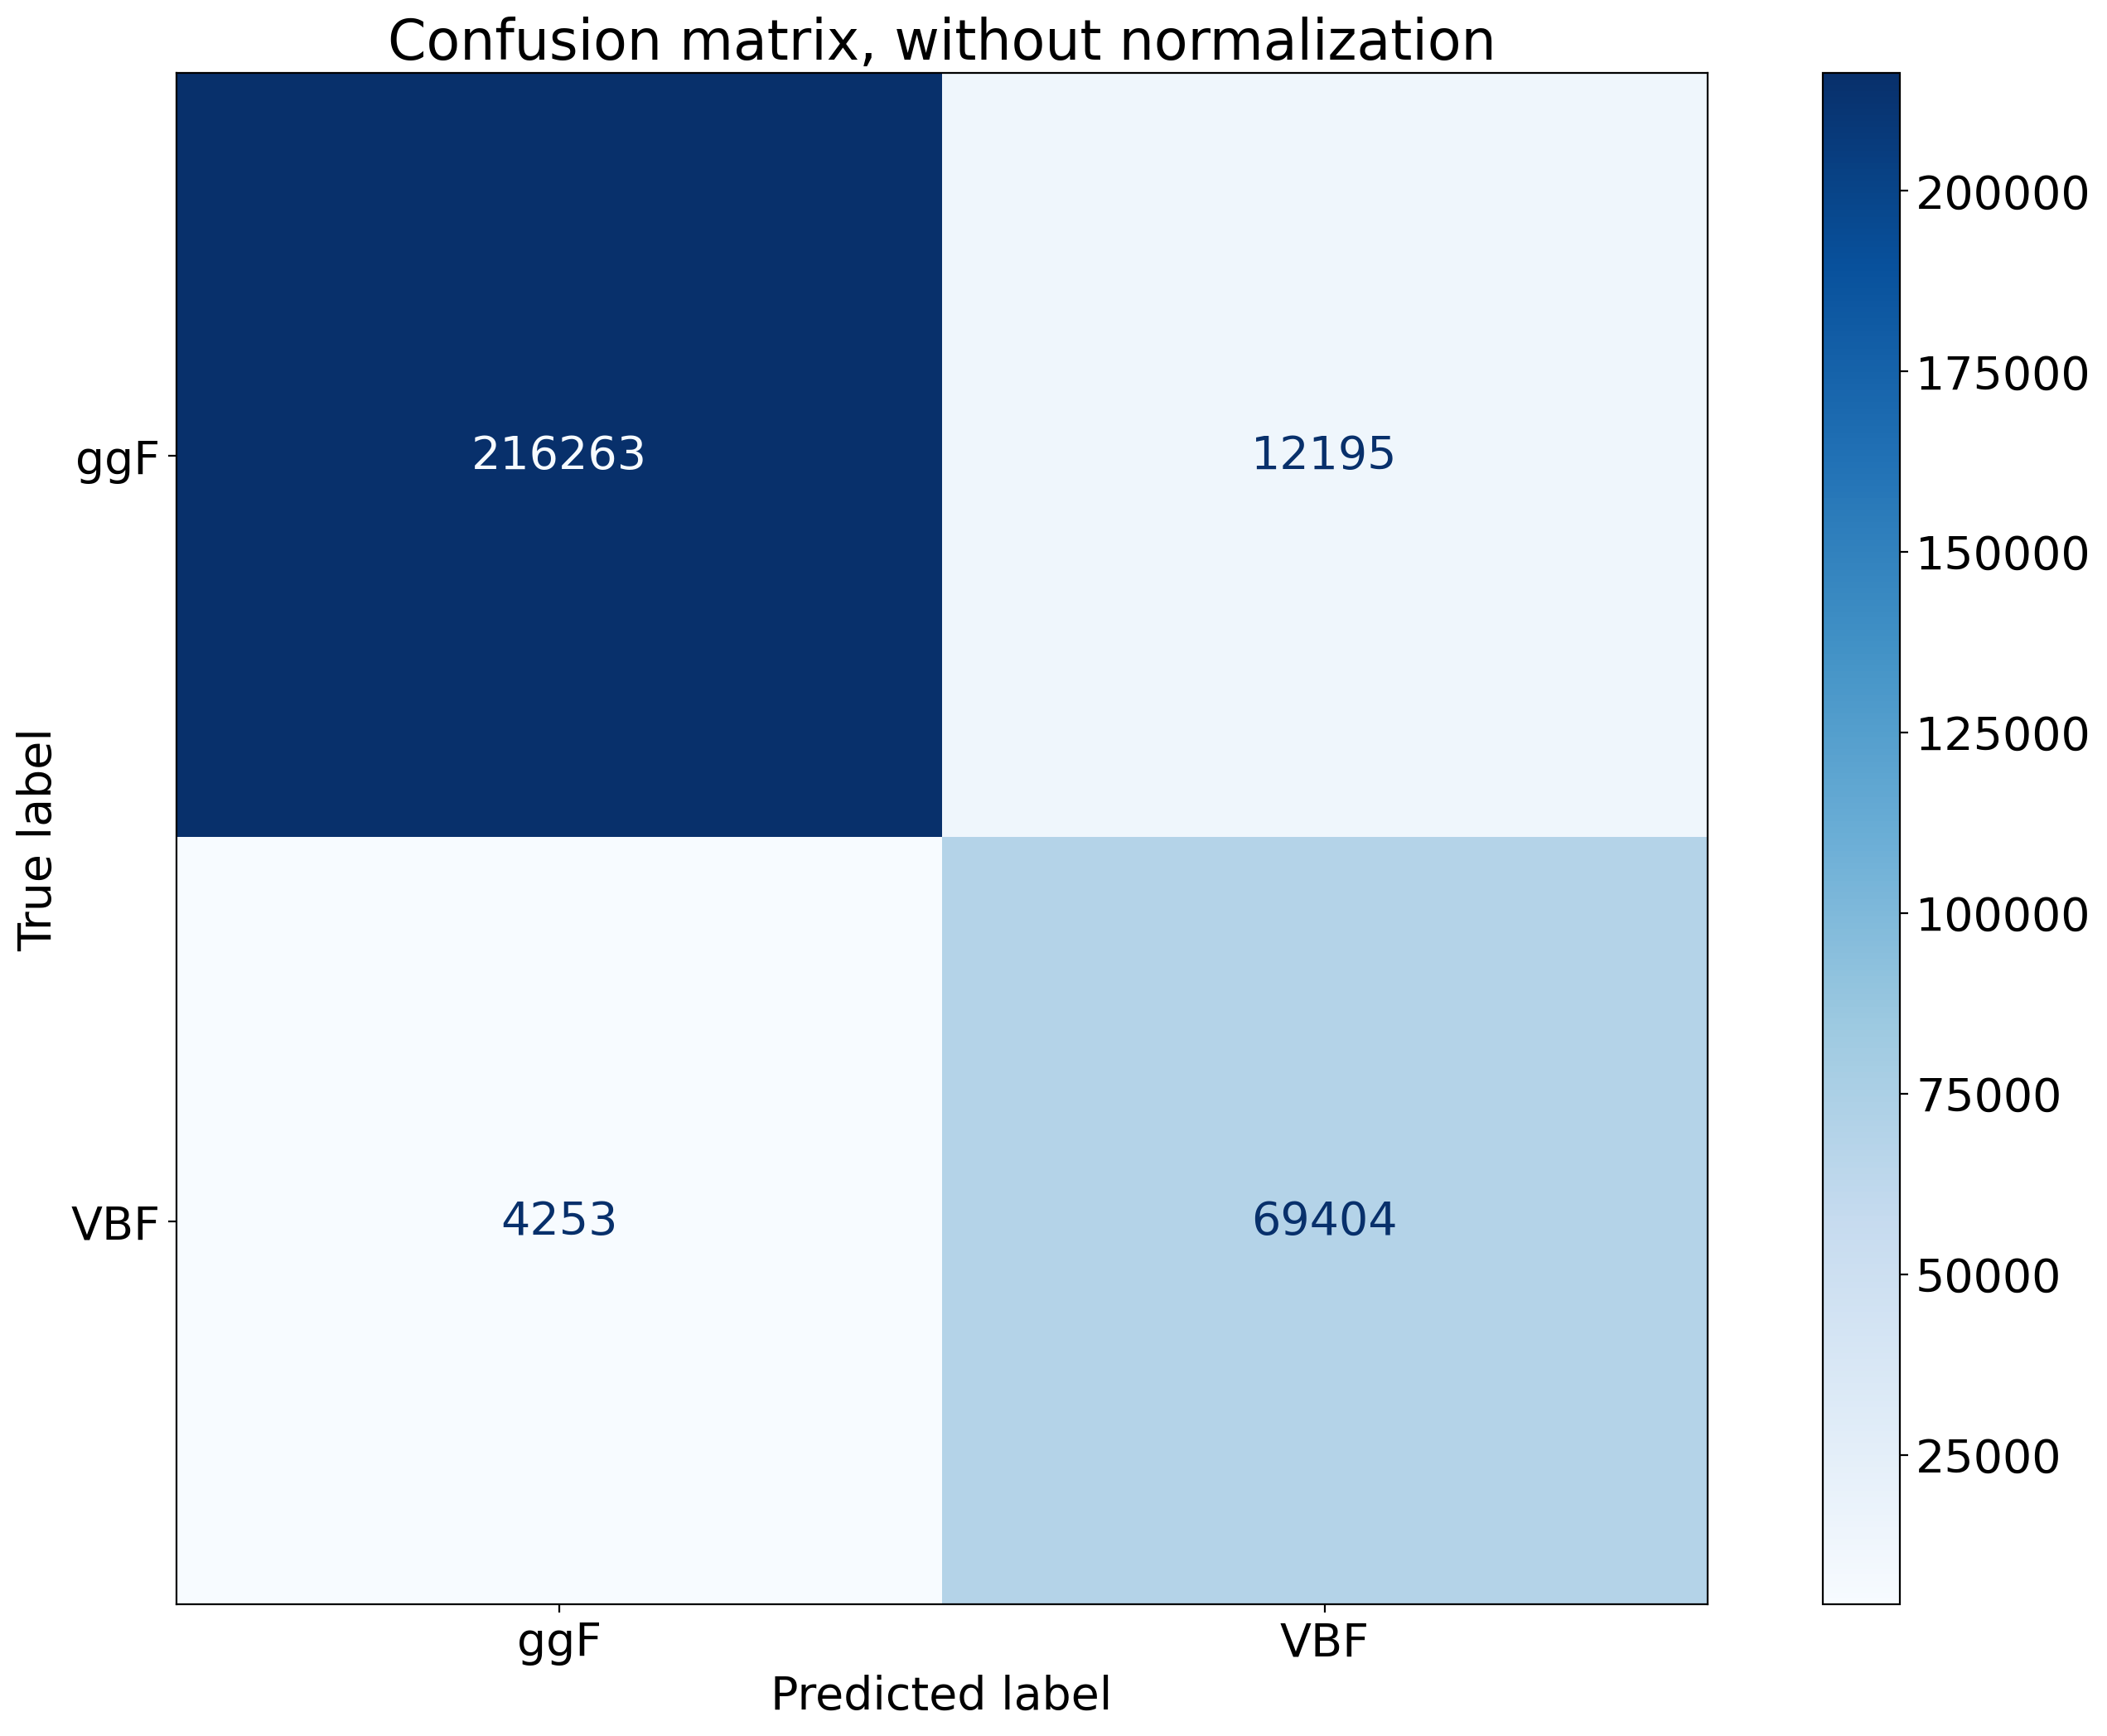

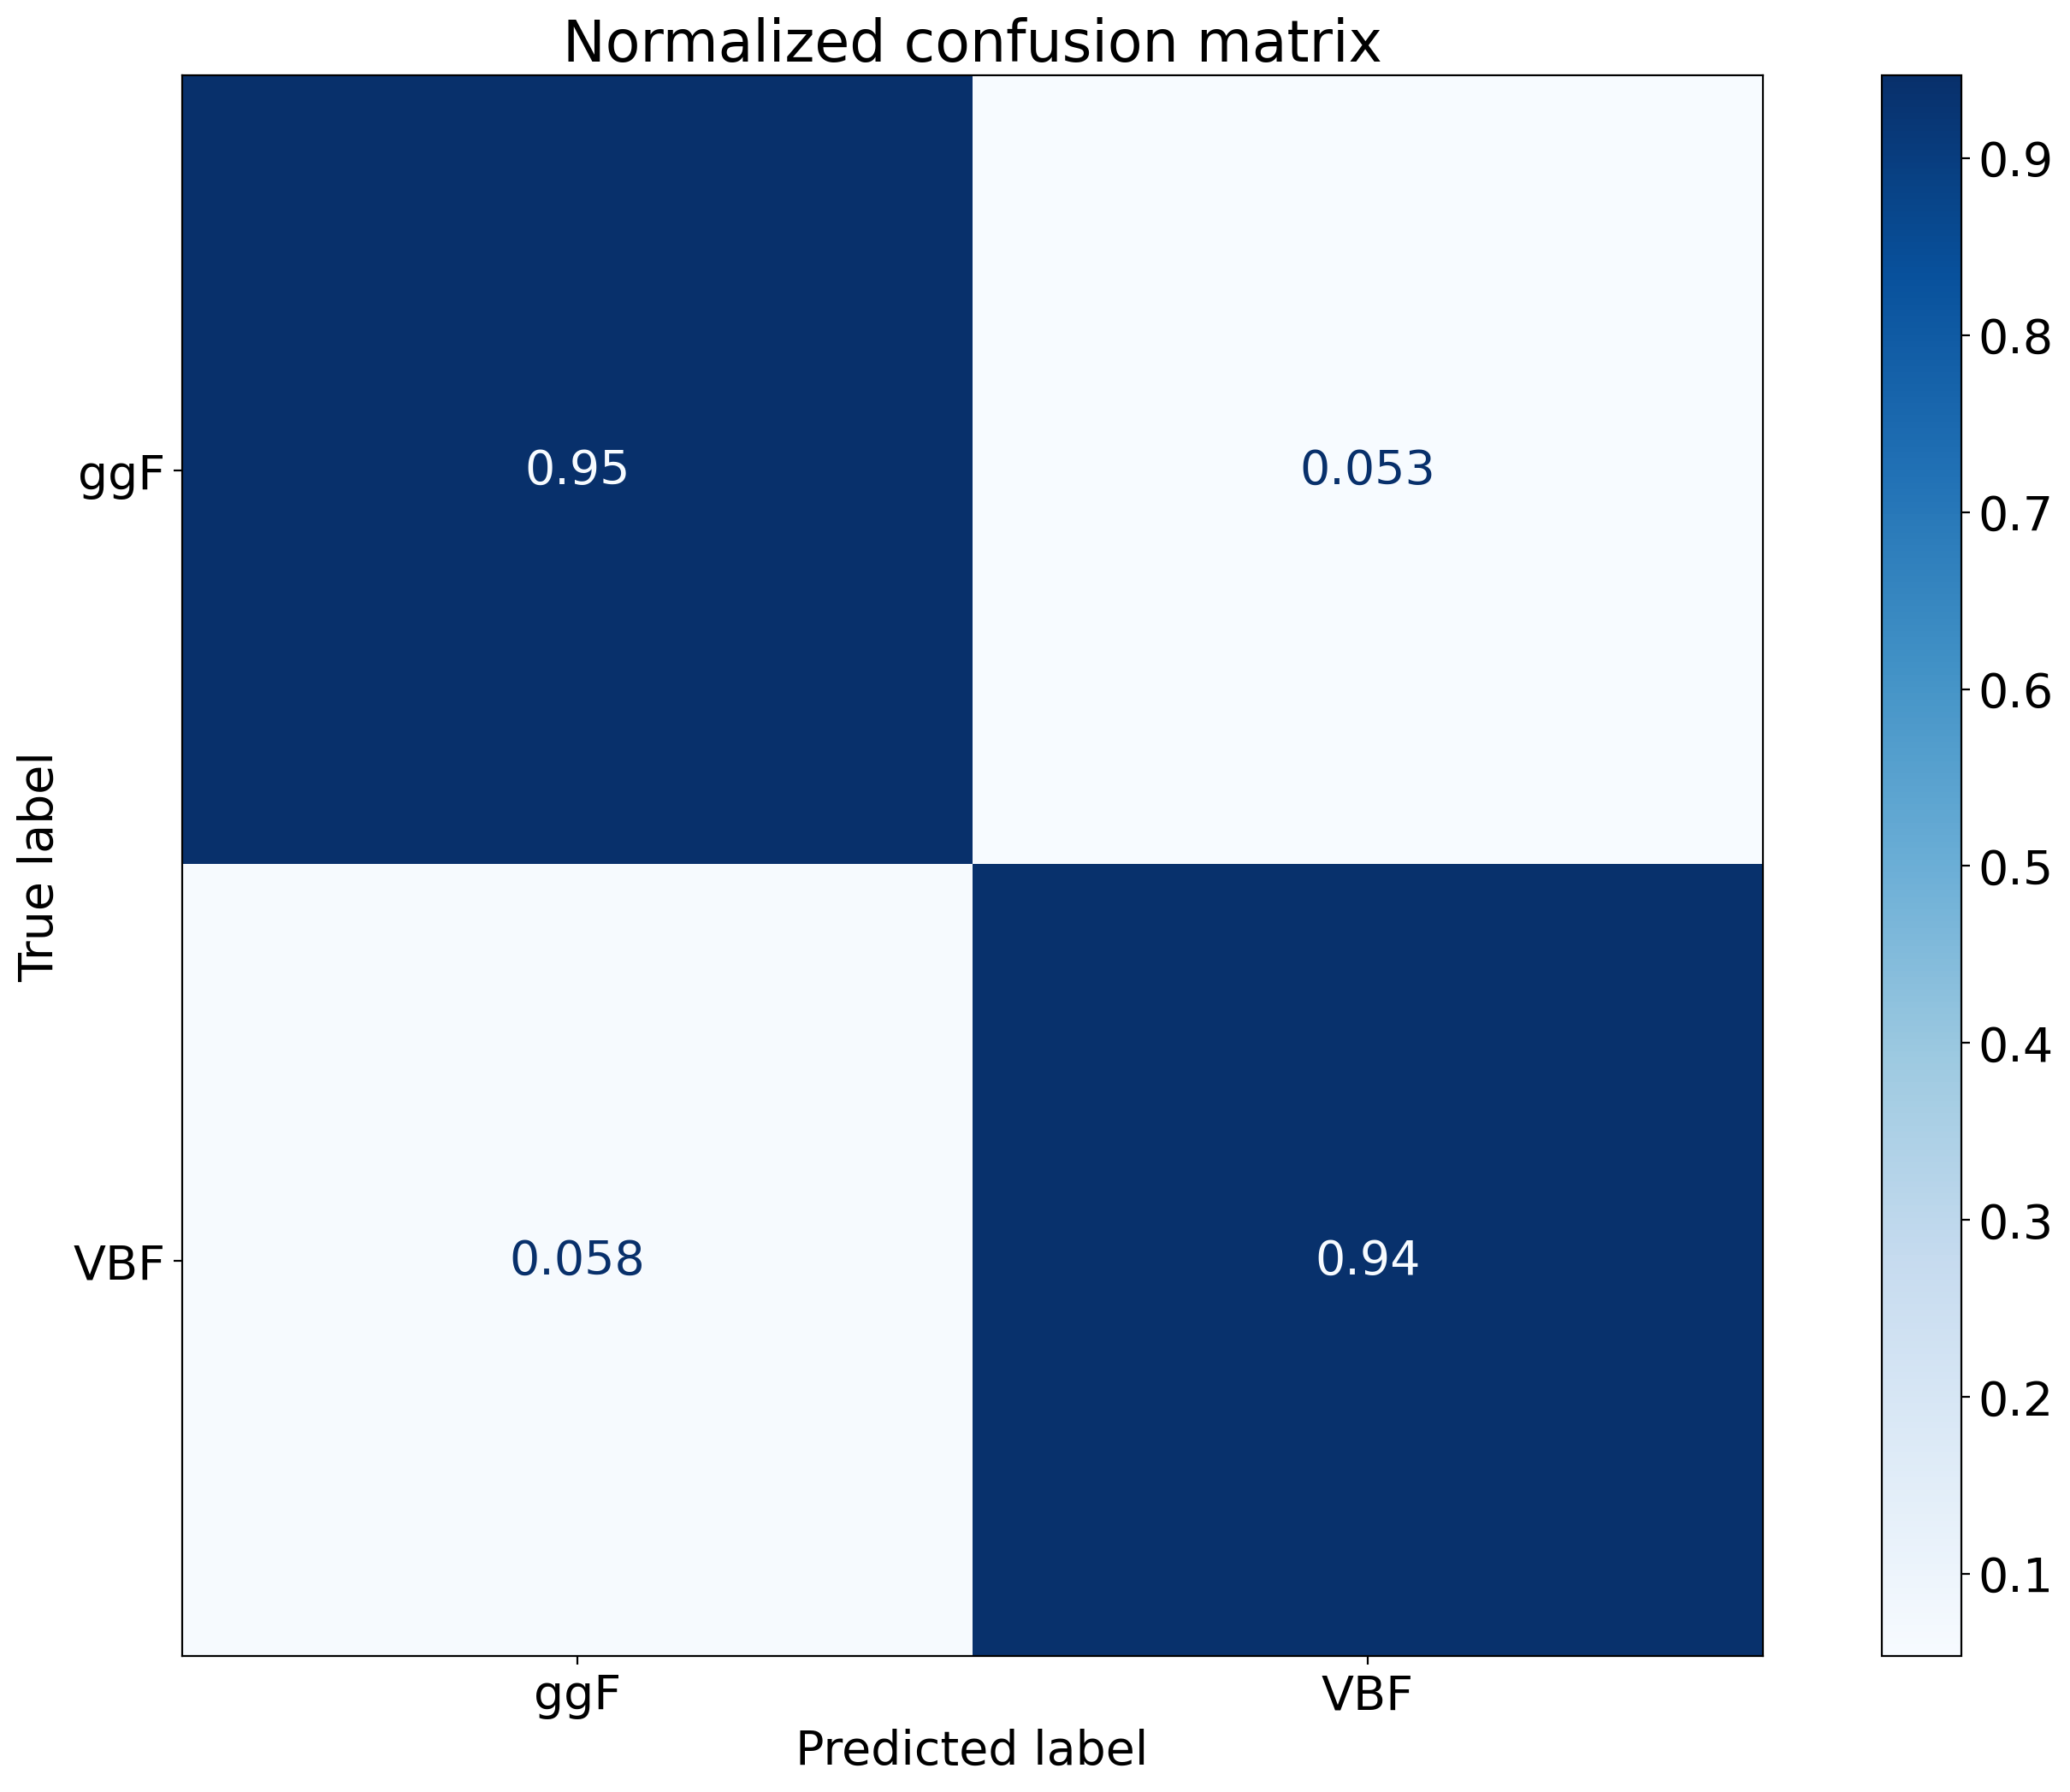

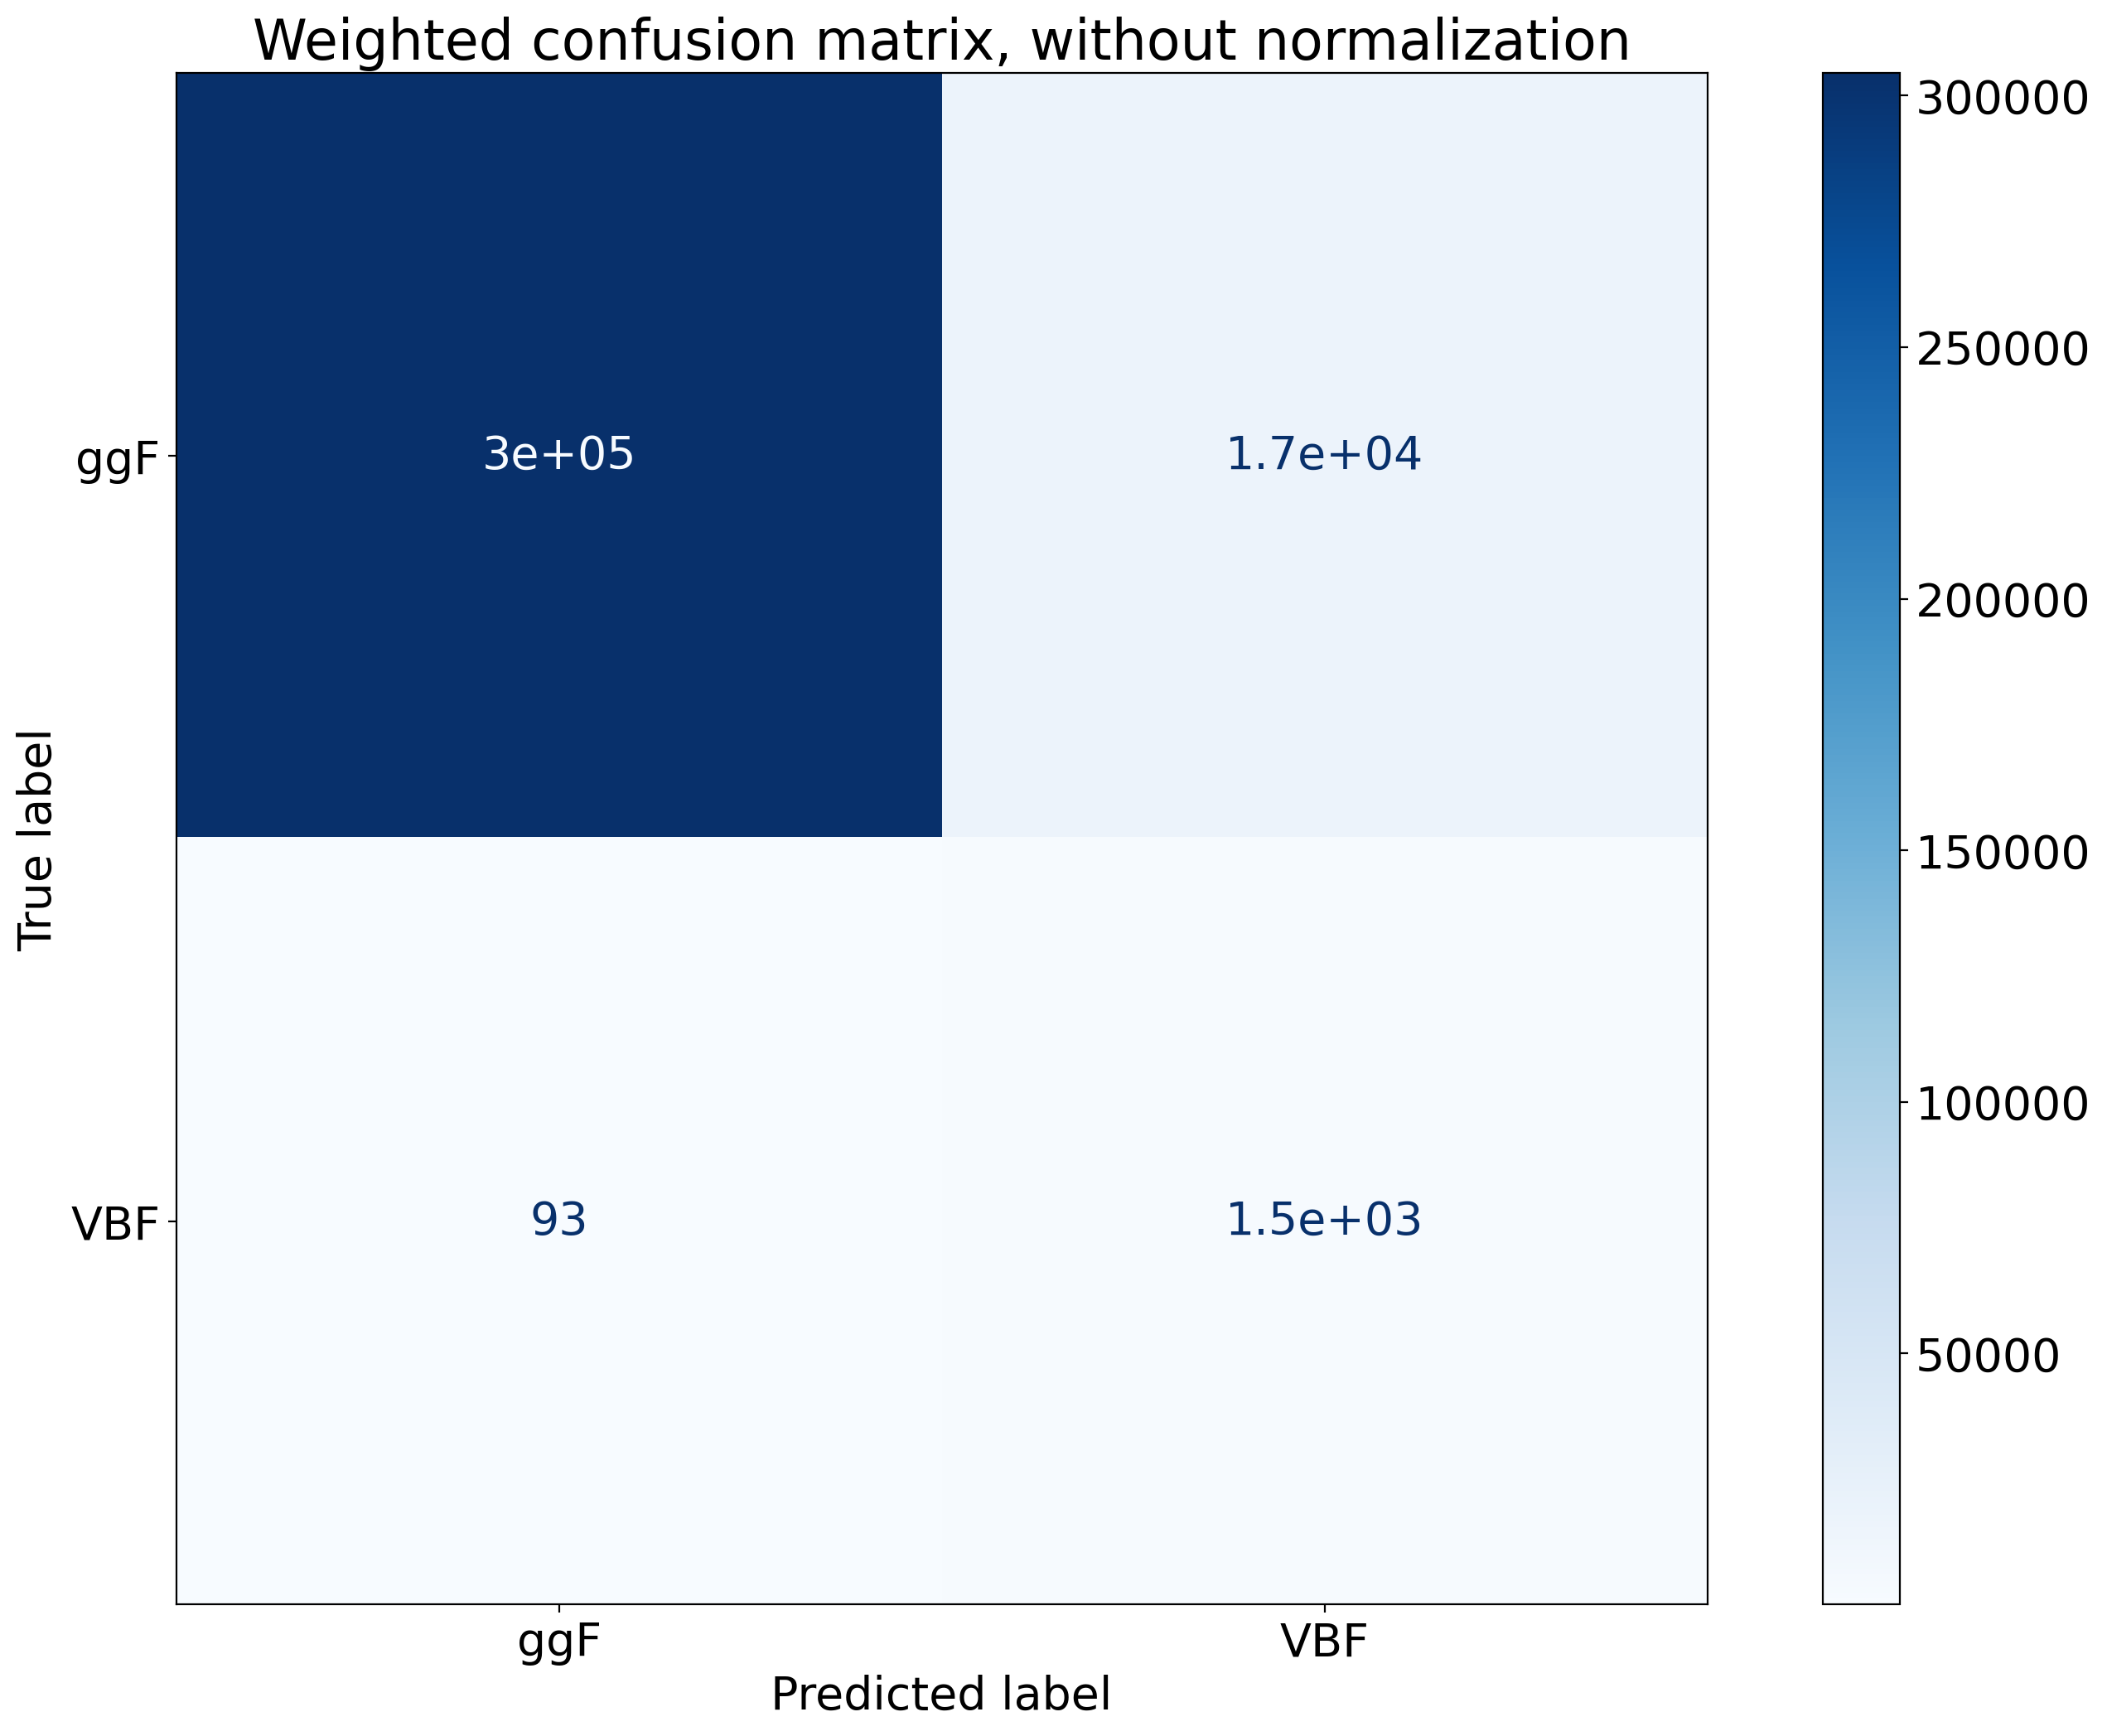

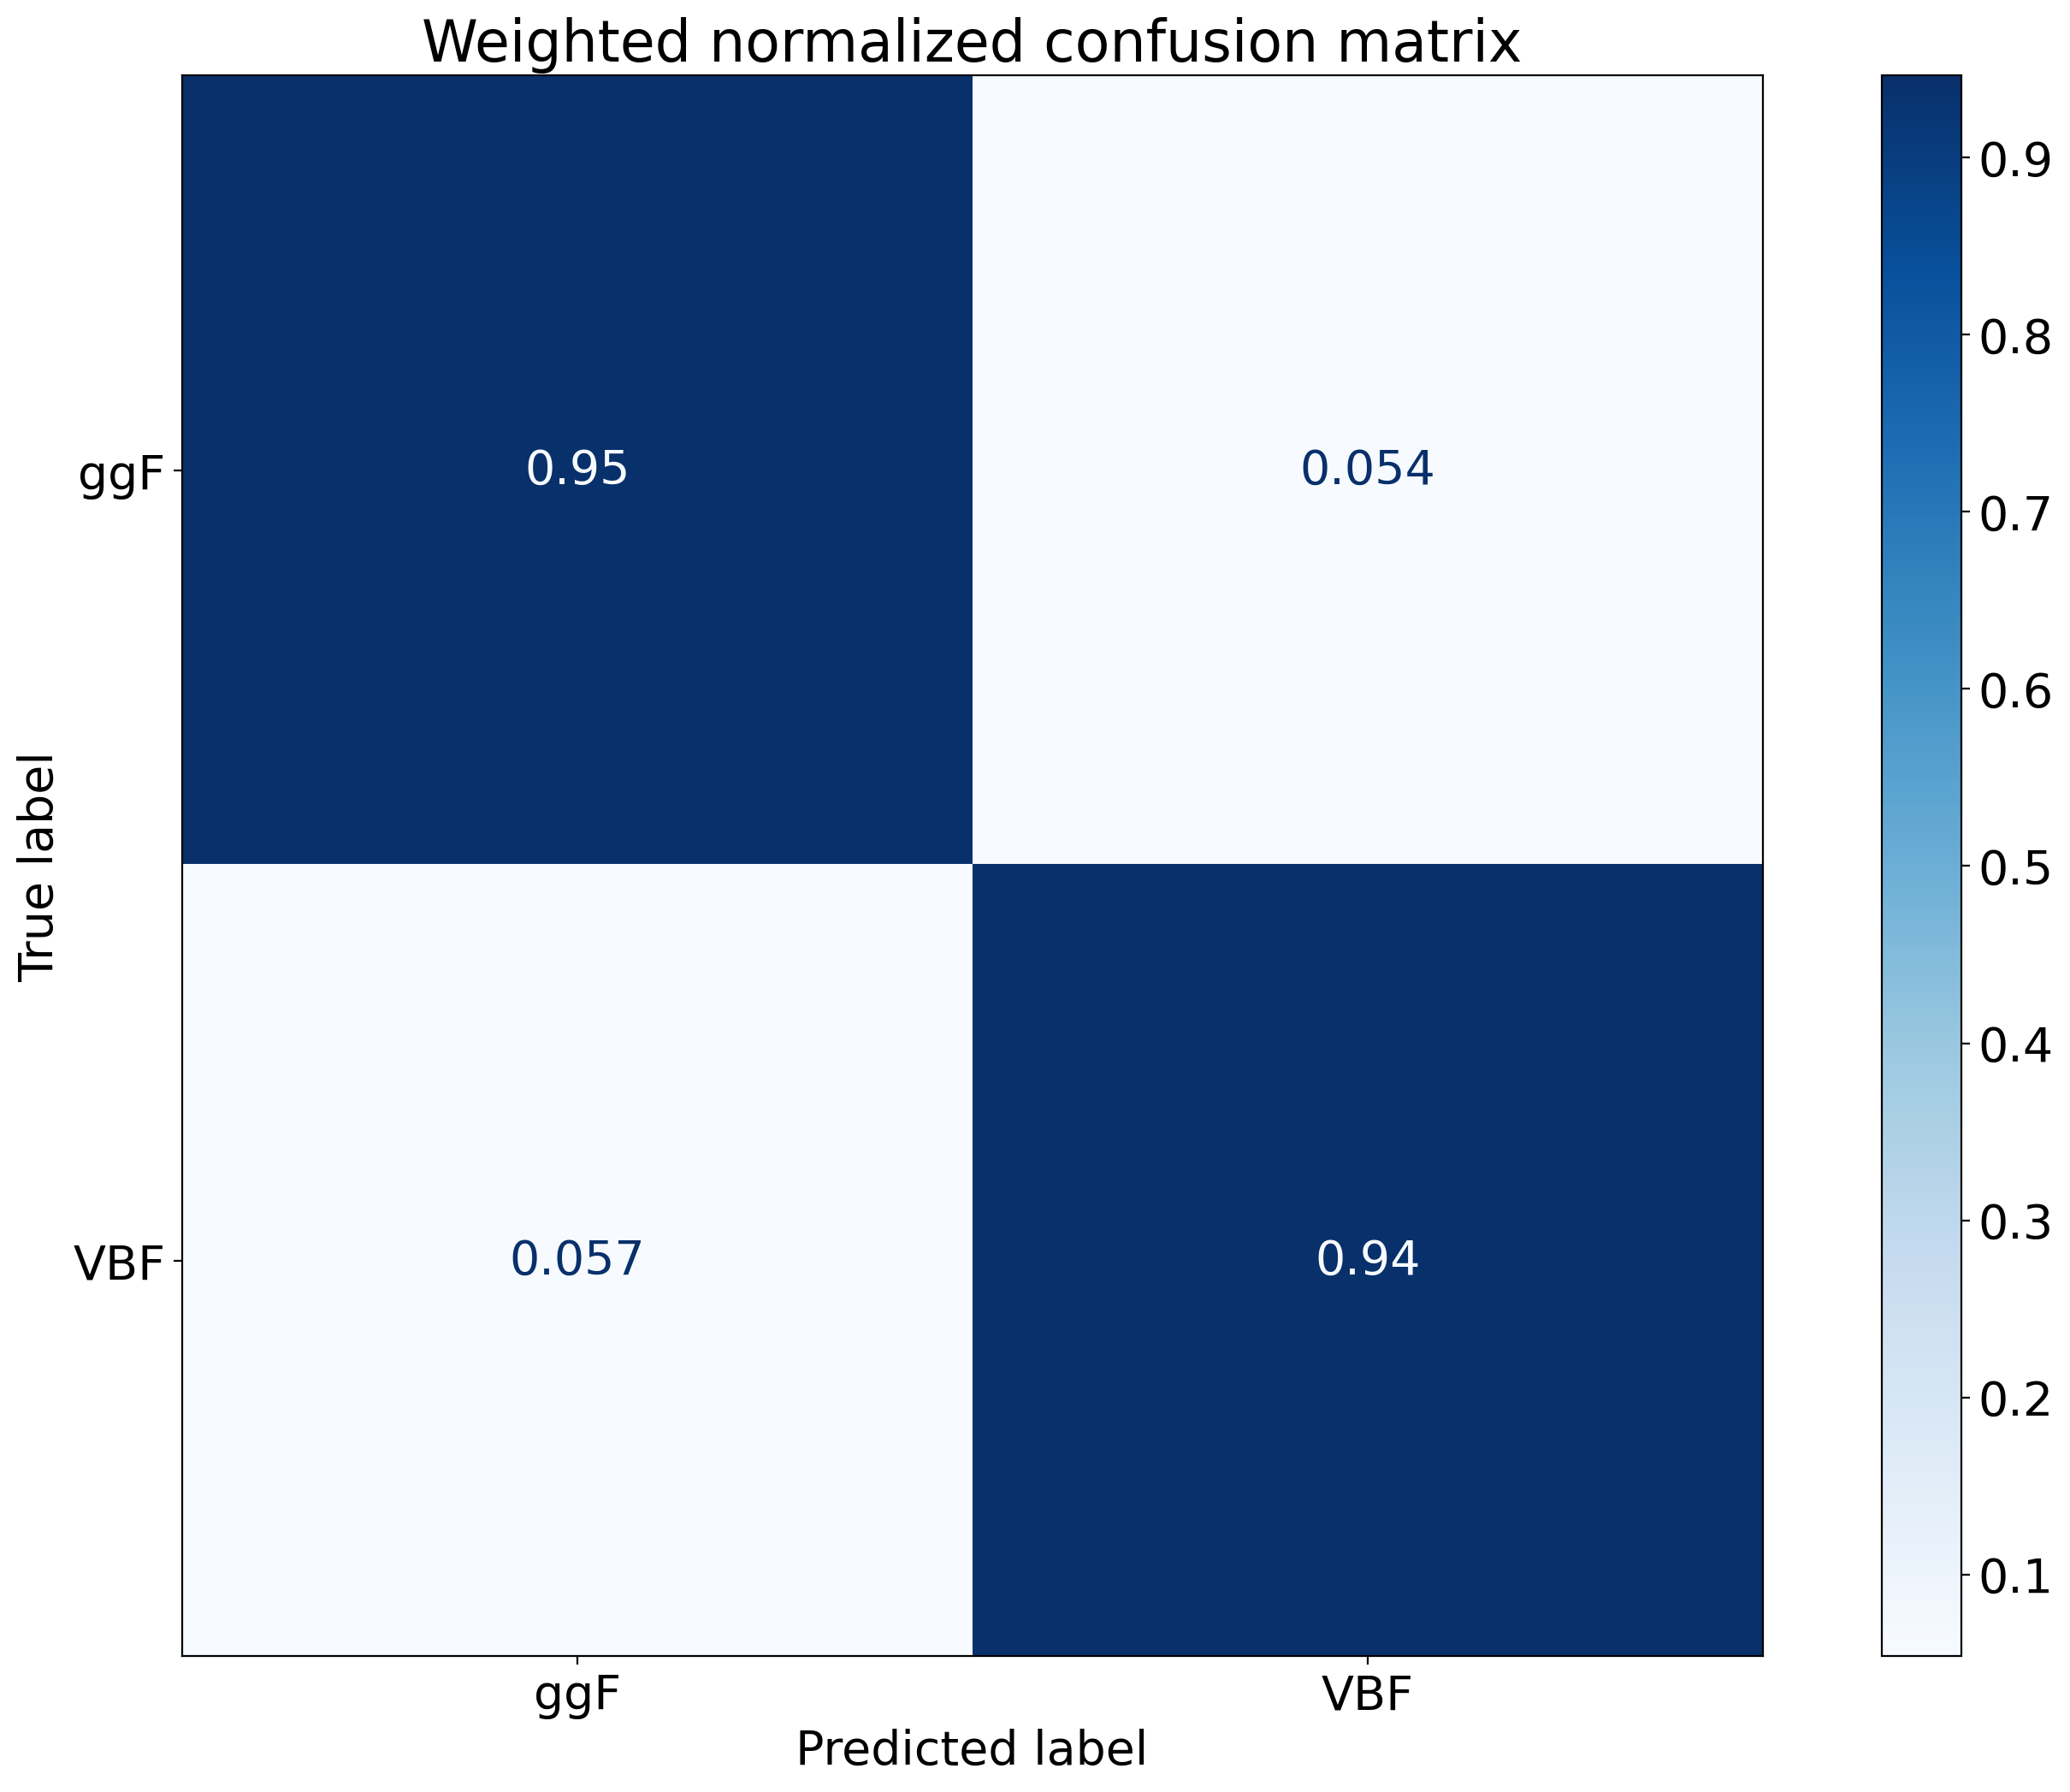

In [239]:
# A confusion matrix is a performance measurement technique for Machine learning classification.
# True_Negative False_Negative
# False_Positive True_Positive
# Performed on val set to avoi info leak from test

division_cut = best_w_cut
y_class = y_pred_val.copy()
y_class[y_pred_val>division_cut]=1.0
y_class[y_pred_val<division_cut]=0.0
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None, None),
                  ("Normalized confusion matrix", 'true', None),
                  ("Weighted confusion matrix, without normalization", None, w_val),
                  ("Weighted normalized confusion matrix", 'true', w_val)]
for title, normalize, w in titles_options:
    # disp = plot_confusion_matrix(reg, X_test, Y_test,
    #                              #display_labels=class_names,
    #                              cmap=plt.cm.Blues,
    #                              normalize=normalize)
    disp = ConfusionMatrixDisplay.from_predictions(y_val, y_class,
                                 normalize=normalize, 
                                 sample_weight=w,
                                 display_labels = ["ggF","VBF"],
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

AUC: 0.9779917434629806


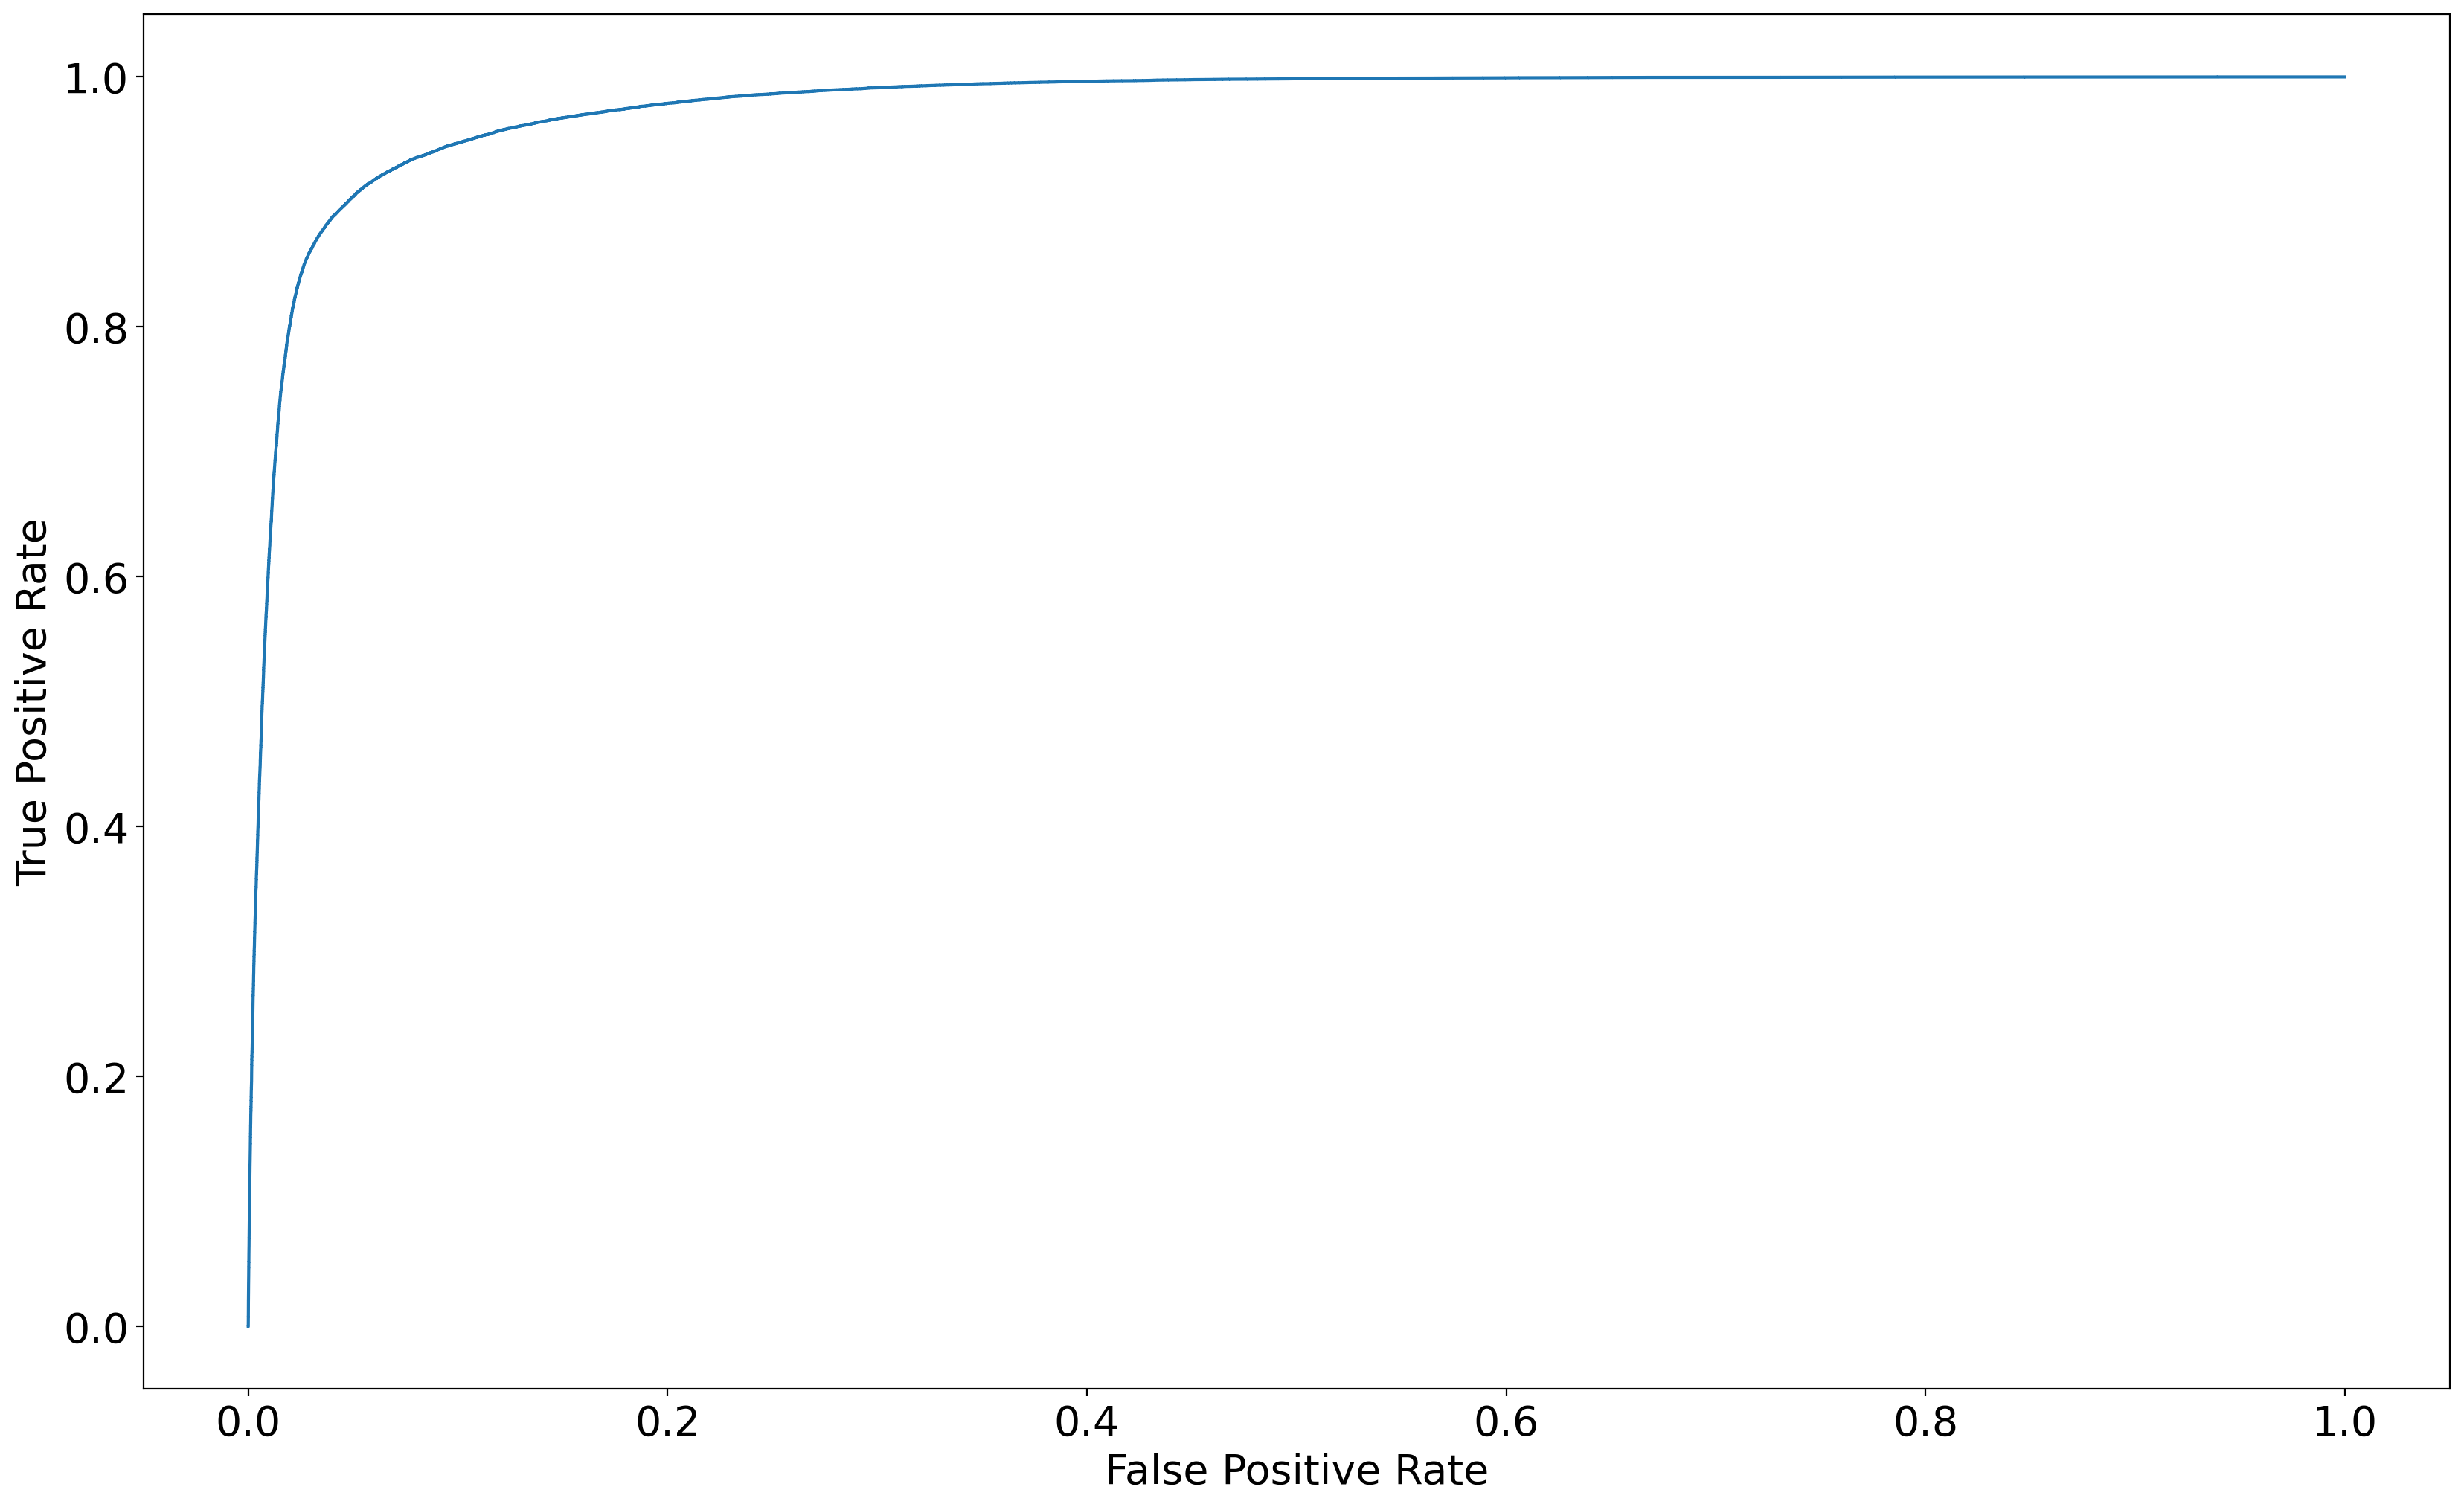

In [220]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [20, 12]

fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
# plt.savefig("auc_prueba.pdf")
print(f"AUC: {auc(fpr, tpr)}")

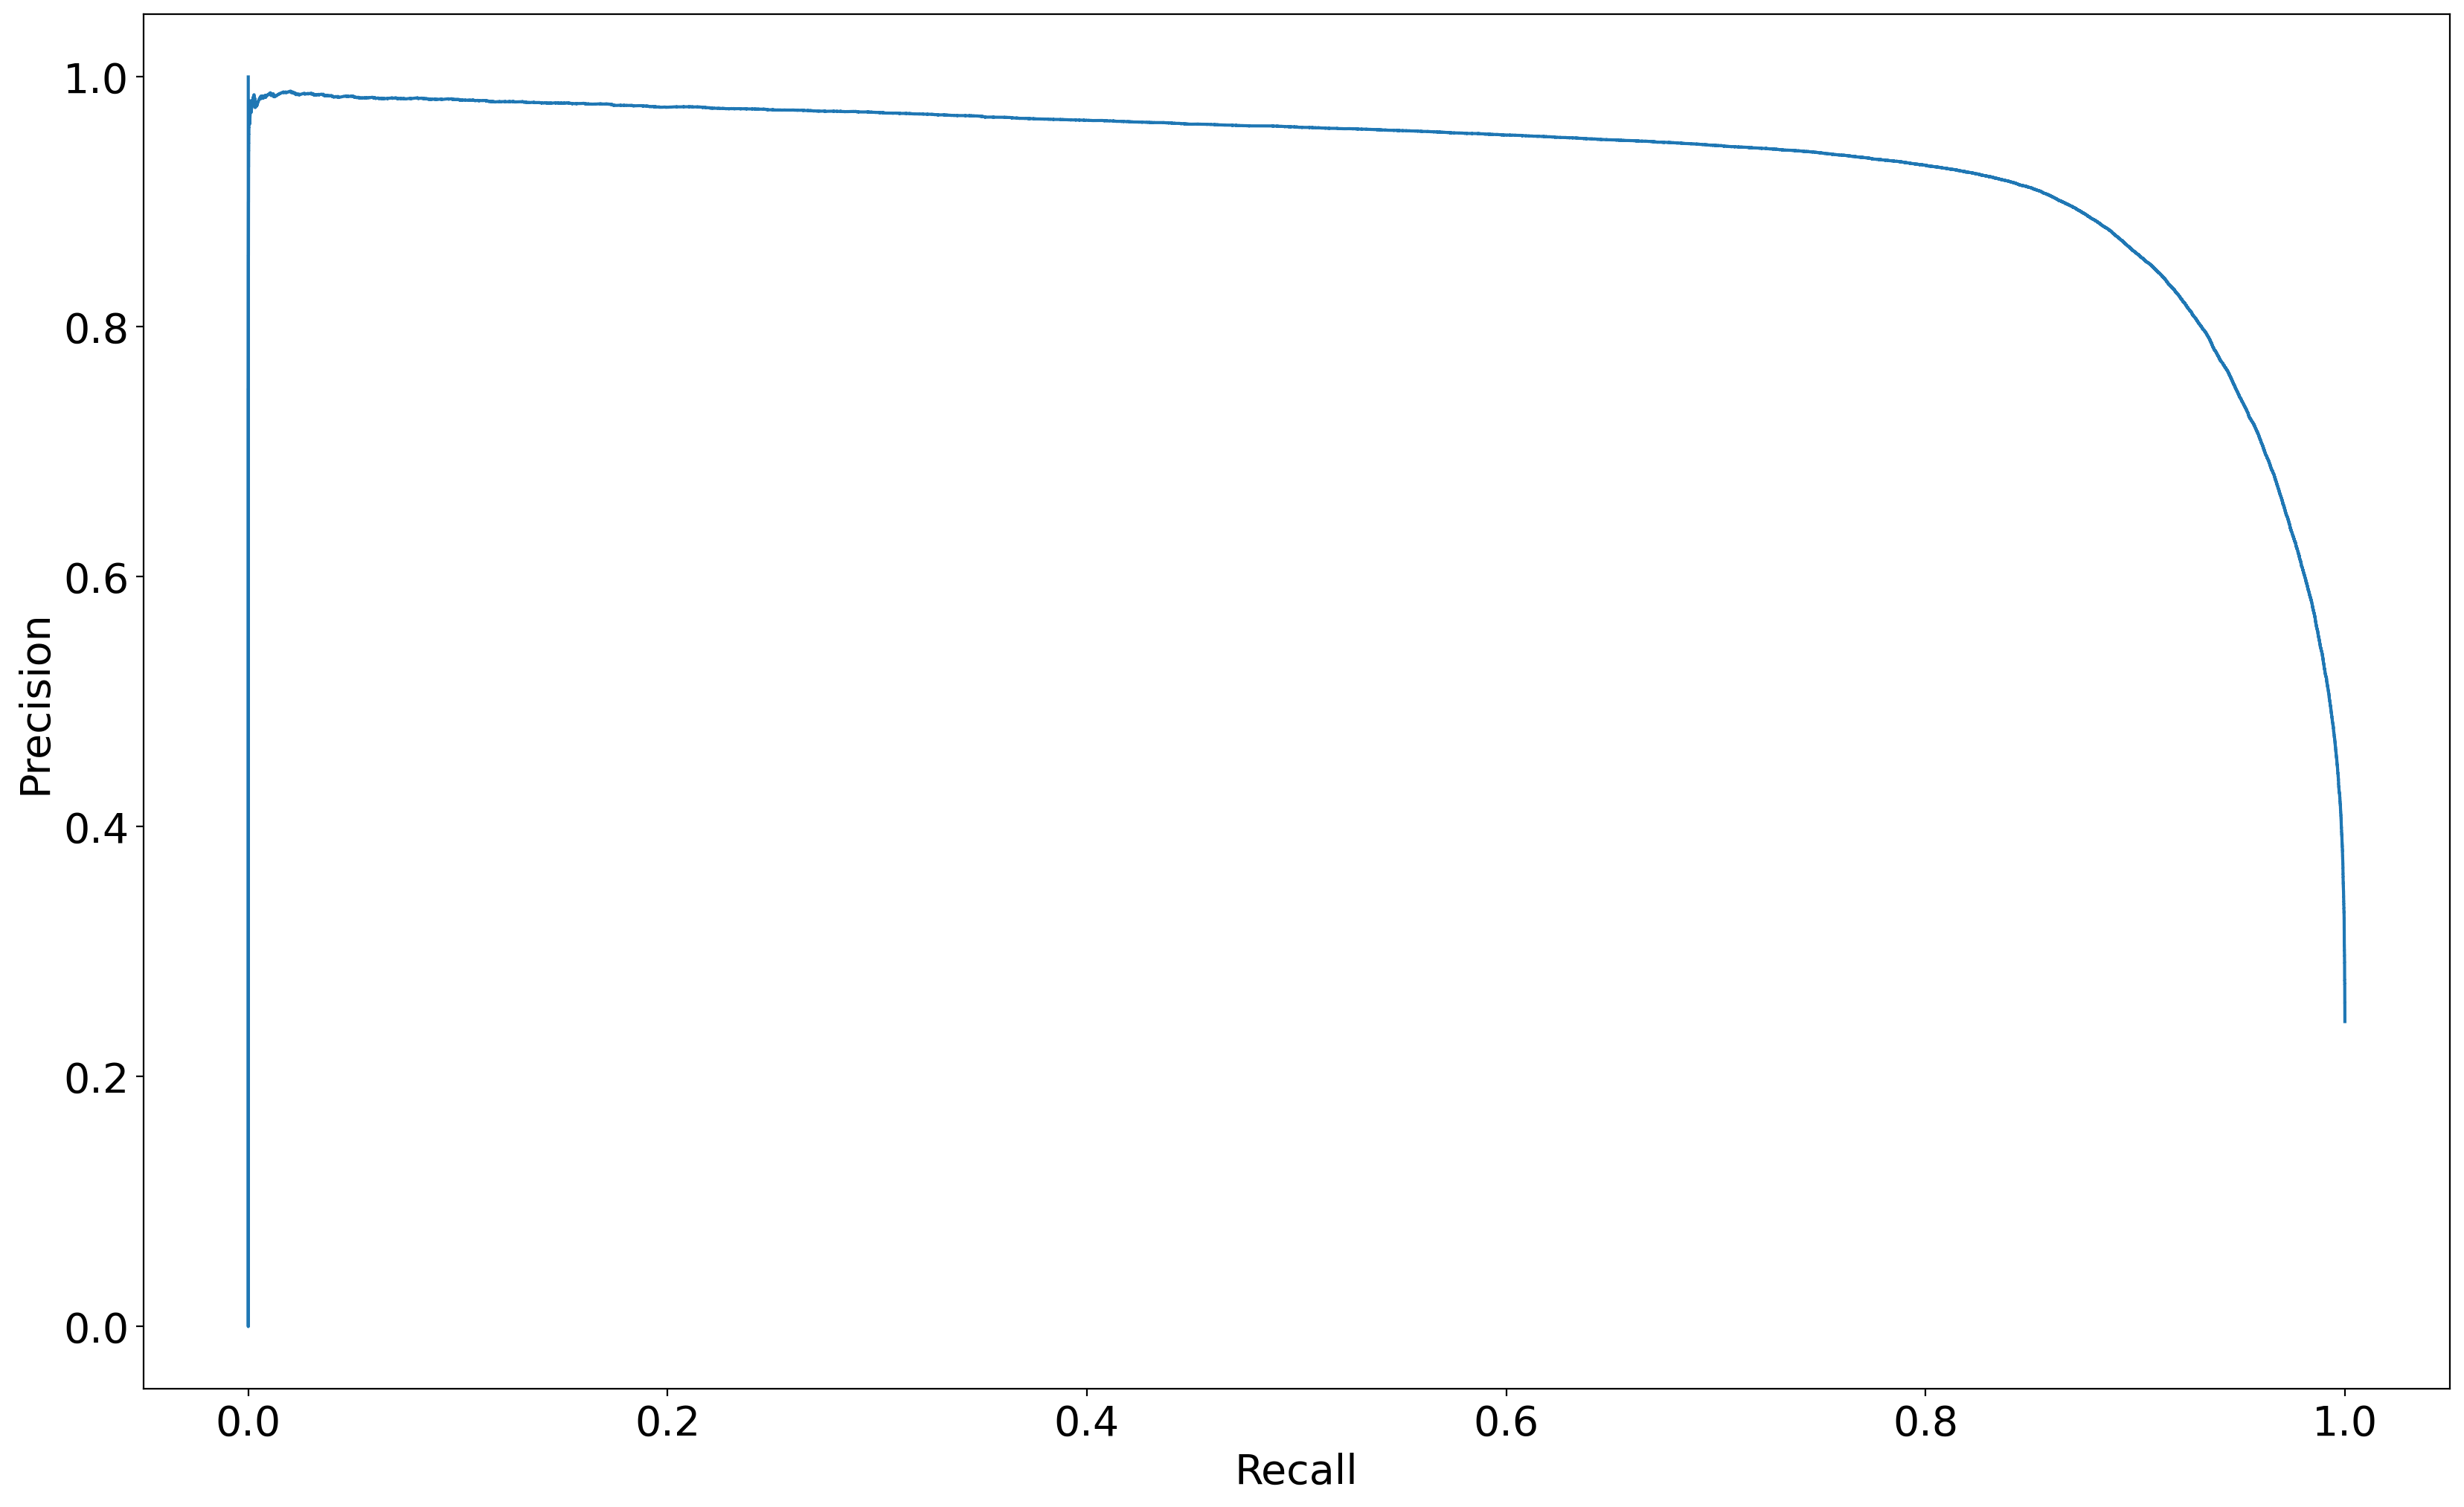

In [221]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, y_pred_test)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [240]:
from scipy import stats
sig_stats = stats.ks_2samp(y_pred_val[y_val == True],y_pred_train[y_train == True], method="exact")
bkg_stats = stats.ks_2samp(y_pred_val[y_val == False],y_pred_train[y_train == False], method="asymp")
sig_p_v = sig_stats.pvalue
bkg_p_v = bkg_stats.pvalue

/tmp/ipykernel_19659/103840601.py:2: RuntimeWarning: Exact ks_2samp calculation not possible with samples sizes 73657 and 343730. Switching to 'asymp'.
  sig_stats = stats.ks_2samp(y_pred_val[y_val == True],y_pred_train[y_train == True], method="exact")


In [241]:
sig_stats.statistic

0.006028615210076638

In [244]:
#define the hist
from scipy.stats import ks_2samp
bins = 20

h = hist.Hist.new.Reg(bins=bins, start=0, stop=1, name="RNN response")    \
    .StrCat(categories=["Train VBF","Train ggF", "Val VBF" ,"Val ggF"
    # , "val VBF", "val ggF"
    ], name="data") \
    .Double()

#fill the hist
h = h.fill(y_pred_val[y_val == True],  data="Val VBF") #weight=w_test[y_test == True],
h = h.fill(y_pred_val[y_val == False],  data="Val ggF") #weight=w_test[y_test == False],

h = h.fill(y_pred_train[y_train == True],  data="Train VBF") #weight=w_train[y_train == True],
h = h.fill(y_pred_train[y_train == False],  data="Train ggF") #weight=w_train[y_train == False],

# h = h.fill(y_pred_val[y_val == True],  data="val VBF") 
# h = h.fill(y_pred_val[y_val == False],  data="val ggF")

# print(f"The signal(background) p-value in Kolmogorov-Smirnov test is: {signal_test.pvalue:.5f}({bkg_test.pvalue:.5f}) ")
# print(f"The KS statistic is: {signal_test.statistic}({bkg_test.statistic})")


plot1 = h.stack("data")
plot1

Stack<('Train VBF', 'Train ggF', 'Val VBF', 'Val ggF') of Hist(Regular(20, 0, 1, name='RNN response'), storage=Double()) # Sum: 343730.0>

/tmp/ipykernel_19659/1017354005.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


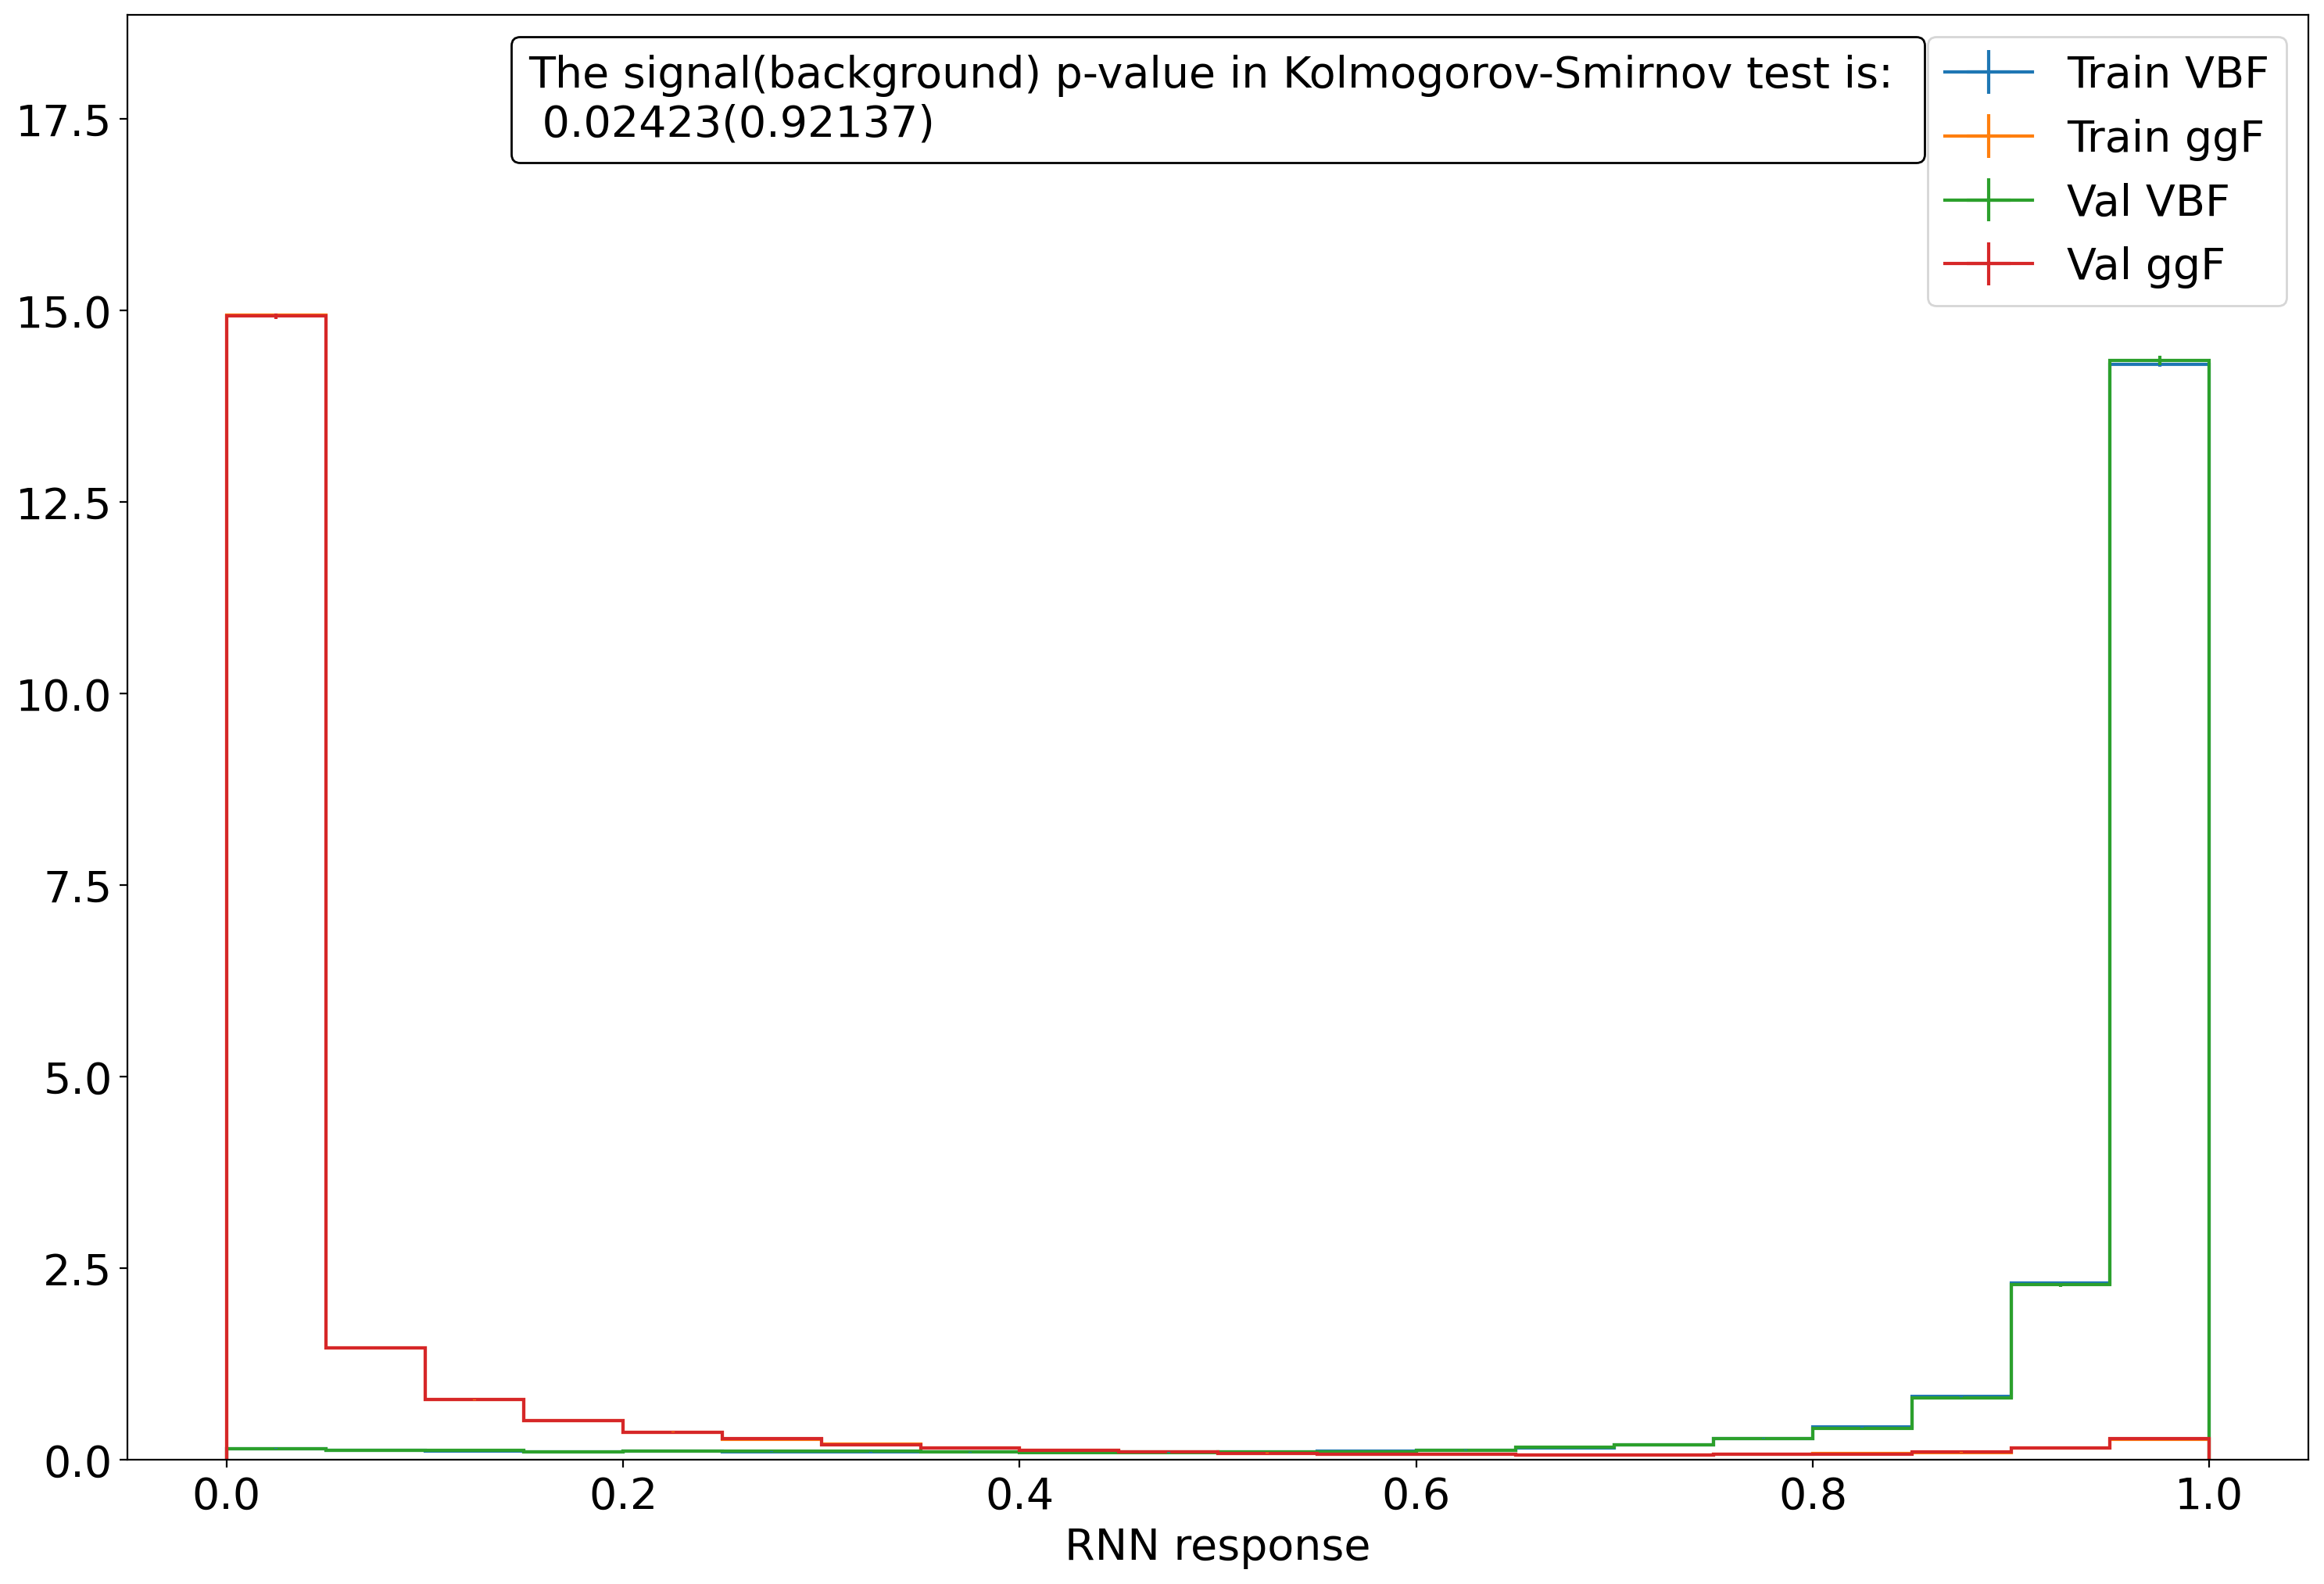

In [245]:
plt.rcParams['figure.figsize'] = (18, 12)
# plt.rcParams["figure.figsize"] = [6.4, 4.8] # default
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.dpi"] = 200
fig, ax = plt.subplots()
at = AnchoredText(
    f"The signal(background) p-value in Kolmogorov-Smirnov test is: \n {sig_p_v:.5f}({bkg_p_v:.5f})",
    prop=dict(size=20),
    frameon=True,
    loc='upper center')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
plot1.plot(density=True, ax=ax)
ax.set_ylim(top=ax.get_ylim()[1]*6/5)
plt.legend(loc="upper right")
fig.show()
# plt.savefig(f"plots/k-s_plot_xgb_scale_pos_weight.pdf")

/tmp/ipykernel_17443/2015214265.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


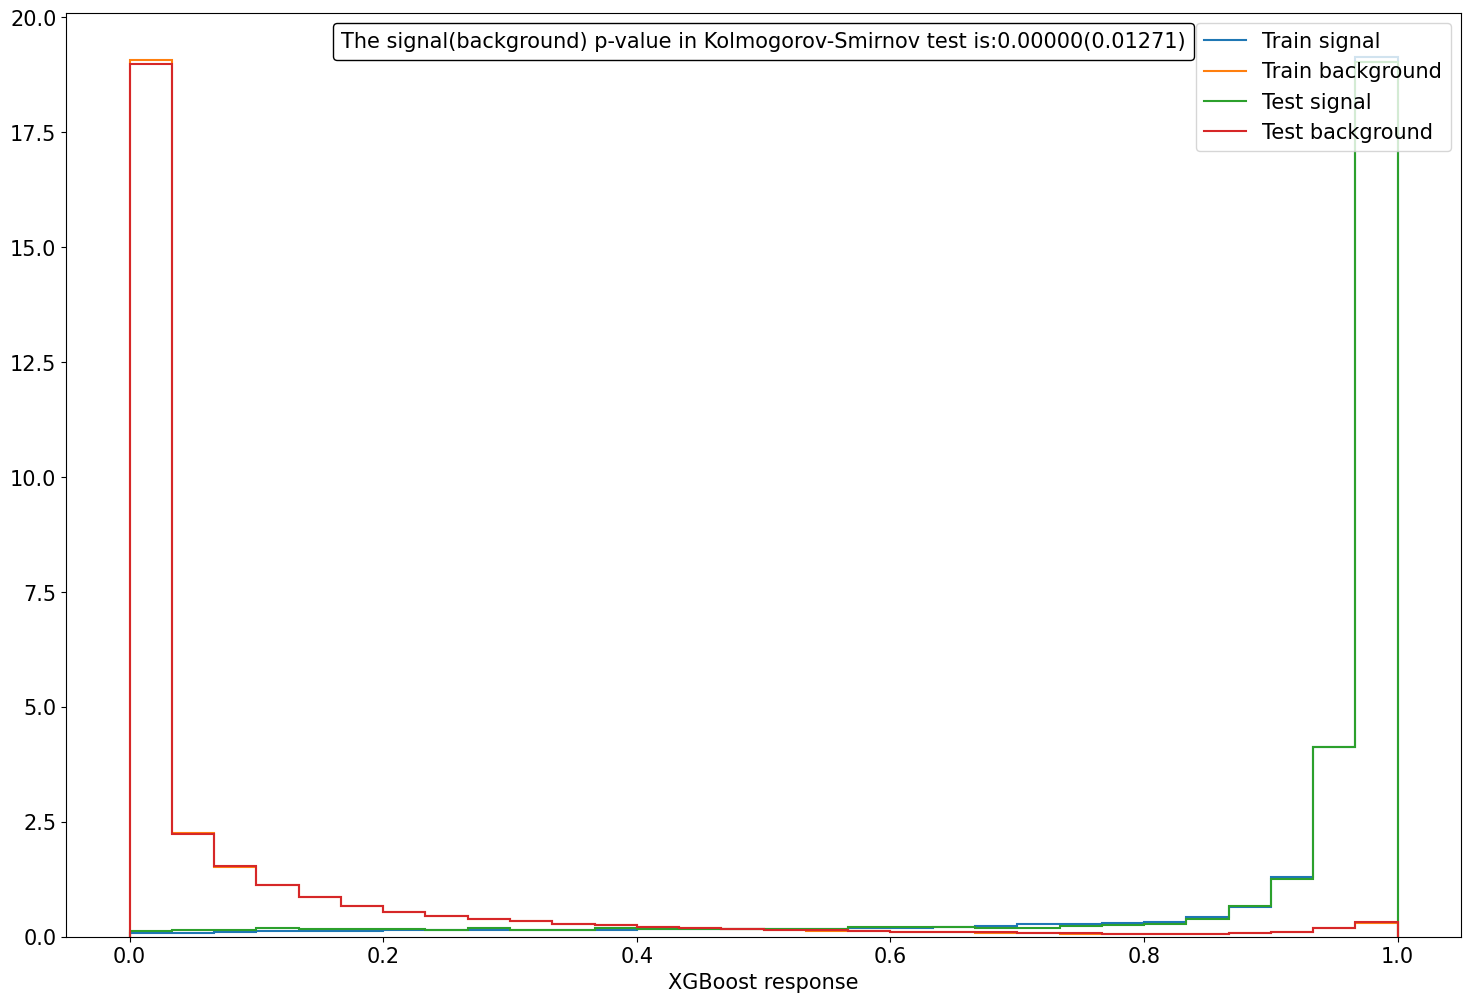

In [194]:
h = hist.Hist.new.Reg(bins=bins, start=0, stop=1, name="XGBoost response")    \
        .StrCat(categories=["Train signal","Train background", "Test signal" ,"Test background"], name="data") \
        .Double()

#fill the hist
h = h.fill(y_pred_test[y_test == True], weight=w_test[y_test == True], data="Test signal") #
h = h.fill(y_pred_test[y_test == False], weight=w_test[y_test == False], data="Test background") #

h = h.fill(y_pred_train[y_train == True], weight=w_train[y_train == True], data="Train signal") #
h = h.fill(y_pred_train[y_train == False], weight=w_train[y_train == False], data="Train background") #

plot1 = h.stack("data")
plot1

sig_stat_w, sig_p_v_w = ks_weighted(y_pred_test[y_test == True], y_pred_train[y_train == True], w_test[y_test == True], w_train[y_train == True] , alternative='two-sided')
bkg_stat_w, bkg_p_v_w = ks_weighted(y_pred_test[y_test == False], y_pred_train[y_train == False], w_test[y_test == False], w_train[y_train == False] , alternative='two-sided')

fig, ax = plt.subplots()
at = AnchoredText(
    f"The signal(background) p-value in Kolmogorov-Smirnov test is:{sig_p_v_w:.5f}({bkg_p_v_w:.5f})",
    prop=dict(size=15),
    frameon=True,
    loc='upper center')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
plot1.plot(density=True, ax=ax)
plt.legend()
fig.show()
# plt.savefig(f"plots/k-s_plot_xgb_scale_pos_weight_weighted.pdf")

In [228]:
reg.get_booster().feature_names = BDT_inputs
xgb.plot_importance(reg)
plt.show()

XGBoostError: [23:39:27] ../src/c_api/c_api_utils.h:230: Check failed: feature_names.size() == n_features (4 vs. 10) : Incorrect number of feature names.
Stack trace:
  [bt] (0) /mnt/c/Users/Cristóbal/Documents/Universidad/Magister/Tesis/JupyterNotebooks/production_mode_classifier/dpj/.venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x128d09) [0x7f65cf91bd09]
  [bt] (1) /mnt/c/Users/Cristóbal/Documents/Universidad/Magister/Tesis/JupyterNotebooks/production_mode_classifier/dpj/.venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x15931b) [0x7f65cf94c31b]
  [bt] (2) /mnt/c/Users/Cristóbal/Documents/Universidad/Magister/Tesis/JupyterNotebooks/production_mode_classifier/dpj/.venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(XGBoosterFeatureScore+0x70a) [0x7f65cf92922a]
  [bt] (3) /home/cristobalchavez21/anaconda3/lib/python3.9/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f663add79dd]
  [bt] (4) /home/cristobalchavez21/anaconda3/lib/python3.9/lib-dynload/../../libffi.so.7(+0x6067) [0x7f663add7067]
  [bt] (5) /home/cristobalchavez21/anaconda3/lib/python3.9/lib-dynload/_ctypes.cpython-39-x86_64-linux-gnu.so(+0x140f6) [0x7f663a6b20f6]
  [bt] (6) /home/cristobalchavez21/anaconda3/lib/python3.9/lib-dynload/_ctypes.cpython-39-x86_64-linux-gnu.so(+0x1073e) [0x7f663a6ae73e]
  [bt] (7) /mnt/c/Users/Cristóbal/Documents/Universidad/Magister/Tesis/JupyterNotebooks/production_mode_classifier/dpj/.venv/bin/python3(_PyObject_MakeTpCall+0x2df) [0x7f663b972caf]
  [bt] (8) /mnt/c/Users/Cristóbal/Documents/Universidad/Magister/Tesis/JupyterNotebooks/production_mode_classifier/dpj/.venv/bin/python3(_PyEval_EvalFrameDefault+0x49a9) [0x7f663ba10d89]



In [ ]:
# from numpy import save
# path = "models/div1/"
# # save to npy file
# save(path+'x_train.npy', x_train)
# save(path+'x_val.npy', x_val)
# save(path+'x_test.npy', x_test)
# save(path+'w_train.npy', w_train)
# save(path+'w_val.npy', w_val)
# save(path+'w_test.npy', w_test)
# save(path+'y_train.npy', y_train)
# save(path+'y_val.npy', y_val)
# save(path+'y_test.npy', y_test)

In [38]:
import cloudpickle
path = "models/div1/centrality/"
with open(path+"BDT_model_centrality_final.pkl", "wb") as o_file:
    cloudpickle.dump(reg, o_file)
# cloudpickle.dump(scaler, open('scaler.pkl', 'wb'))<
